Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

In [8]:
import matplotlib.pyplot as plt
import platform

def get_font_family():
    system_name = platform.system()
    if system_name == "Darwin":
        return "AppleGothic"
    elif system_name == "Windows":
        return "Malgun Gothic"
    elif system_name == "Linux":
        return "NanumGothic"
    return None

# 한글 폰트 설정
font_family = get_font_family()
plt.rc("font", family=font_family)
plt.rc('axes', unicode_minus=False)

# Jupyter Notebook에서 retina 디스플레이 지원
%config InlineBackend.figure_format='retina'

# Chapter 9 - Modeling Volatility with GARCH class models

**제 6장, 시계열 분석 및 예측** 에서는 시계열 모델링에 접근하는 다양한 방법을 다룹니다. 그러나 **ARIMA** (자기회귀 통합 이동평균)와 같은 모델은 시간이 지남에 따라 일정하지 않은 변동성(이분산성)을 설명하지 못합니다. 우리는 이미 로그 변환이나 Box-Cox 변환과 같은 몇 가지 변환을 사용하여 적은 변동성을 조정할 수 있음을 설명했지만, 이제 한 단계 더 나아가 이를 모델링하려고 합니다.

이 장에서는 **조건부 이분산성** 에 중점을 두고 있으며, 이는 변동성 증가가 추가적인 변동성 증가와 상관관계를 가질 때 발생하는 현상입니다. 이 개념을 이해하는 데 도움이 되는 예로는, 회사 관련 중요한 뉴스로 인해 자산 가격이 급락하는 상황을 상상할 수 있습니다. 이러한 갑작스러운 가격 하락은 투자 펀드의 위험 관리 도구를 활성화하여 주식을 매도하게 만들 수 있습니다. 이는 이전 가격 하락의 결과로 가격이 더욱 하락하는 결과를 초래할 수 있습니다. 조건부 이분산성은 자산 수익의 규칙적인 변동성을 조사한 **자산 수익의 양식화된 사실 조사** 에서 명확하게 나타났습니다. 여기에서 수익이 변동성 클러스터링을 보인다는 것을 보여주었습니다.

이 장에 대한 동기를 간단히 설명하고자 합니다. 변동성은 금융에서 매우 중요한 개념으로, 위험과 동의어입니다. 첫째, 변동성은 옵션 가격 결정에 사용되며, Black-Scholes 모델은 기초 자산의 변동성에 의존합니다. 둘째, 변동성은 위험 관리에 중요한 영향을 미칩니다. 이는 포트폴리오의 **VaR(위험 가치)** 나 **샤프 지수** 등 다양한 지표를 계산하는 데 사용됩니다. 셋째, 변동성은 트레이딩에서도 나타납니다. 일반적으로 트레이더들은 자산 가격의 상승이나 하락에 대한 예측을 기반으로 결정을 내리지만, 변동성 자체에 대한 예측을 기반으로 거래를 할 수도 있습니다. 즉, 가격이 어느 방향으로 움직일지는 알 수 없으나, 변동성이 있을 것이라는 예측입니다. 특히 팬데믹과 같은 세계적인 사건이 시장을 불규칙하게 움직이게 할 때 변동성 거래가 매우 매력적일 수 있습니다. 변동성 트레이더들에게 흥미로운 상품의 예로는 **S&P 500 지수** 의 움직임을 기반으로 한 **VIX(변동성 지수)** 가 있습니다.

이 장이 끝날 때쯤에는 **GARCH(Generalized Autoregressive Conditional Heteroskedasticity, 일반화 자기회귀 조건부 이분산성)** 모델의 여러 유형을 다루게 될 것입니다. GARCH는 단변량과 다변량을 포함하며, 변동성을 모델링하고 예측하는 데 있어 가장 인기 있는 방법 중 일부입니다. 기본을 알면 더 복잡한 모델을 쉽게 구현할 수 있습니다. 우리는 이미 금융에서 변동성의 중요성에 대해 언급했습니다. 변동성을 모델링할 수 있게 되면, 이를 리스크 관리 또는 파생상품 평가와 같은 실무적인 사용 사례에서 이전의 단순한 예측을 대체하는 데 사용할 수 있습니다.

이 장에서는 다음 내용을 다룹니다:

- **ARCH 모델**을 사용한 주식 수익 변동성 모델링
- **GARCH 모델**을 사용한 주식 수익 변동성 모델링
- **GARCH 모델**을 사용한 변동성 예측
- **CCC-GARCH 모델**을 사용한 다변량 변동성 예측
- **DCC-GARCH**를 사용한 조건부 공분산 행렬 예측

## 9.1 Modeling stock returns' volatility with ARCH models

이 예제에서는 **자기회귀 조건부 이분산성(ARCH)** 모델을 사용하여 주식 수익의 조건부 변동성을 모델링하는 문제를 다룹니다.

간단히 말해서, **ARCH 모델**은 과거 오류의 함수로 오류 항의 분산을 표현합니다. 좀 더 정확히 말하면, 오류의 분산이 자기회귀 모델을 따른다고 가정합니다. **ARCH 방법**의 전체 논리는 다음 방정식들로 표현할 수 있습니다:

$
r_t = \mu + \epsilon_t
$

$
\epsilon_t = \sigma_t z_t
$

$
\sigma^2_t = \omega + \sum_{i=1}^{q} \alpha_i \epsilon^2_{t-i}
$

- 첫 번째 방정식은 기대 수익 μ와 예상치 못한 수익 εₜ의 조합으로 수익 시계열을 나타냅니다.
- 두 번째 방정식에서 **εₜ**는 조건부 표준 편차 **σₜ**와 백색 잡음 **zₜ**의 곱으로 표현됩니다.
- 세 번째 방정식은 **ARCH 모델**을 나타내며, 과거의 오류 제곱의 가중 합계로 조건부 분산 **σ²ₜ**를 설명합니다. 여기서 **ω > 0**과 **αᵢ ≥ 0**입니다.

이 방정식들은 시계열의 조건부 평균을 0으로, 그리고 조건부 분산을 시간에 따라 변화하는 것으로 설정합니다.

오류 항들은 시계열적으로 상관되지 않지만, 조건부 이분산성을 나타낼 수 있기 때문에 반드시 독립적일 필요는 없습니다.

>**εₜ**는 평균이 조정된 수익, 오류 항, 혁신 또는 가장 일반적으로 잔차로도 알려져 있습니다.

일반적으로, **ARCH(그리고 GARCH) 모델**은 원래 시계열에 적용된 다른 모델의 잔차에만 적합해야 합니다. 변동성 모델을 추정할 때, 우리는 평균 과정의 다양한 명세를 가정할 수 있습니다. 예를 들어:

- **평균이 0인 과정** – 이는 수익이 오직 잔차에 의해서만 설명된다는 것을 의미합니다. 예를 들어: 
  $
  r_t = \epsilon_t
  $
- **평균이 상수인 과정**:
  $
  r_t = \mu + \epsilon
  $
- **AR, ARMA, ARIMA** 또는 최신 이질적 자기회귀(HAR) 과정과 같은 선형 모델을 사용하여 추정된 평균


두 번째 방정식에서는 **오류 시계열**을 확률적 구성 요소 **zₜ ~ N(0, 1)** 와 조건부 표준 편차 **σₜ**로 나타냅니다. 이는 잔차의 일반적인 크기를 나타냅니다. 확률적 구성 요소는 표준화된 잔차로도 해석될 수 있습니다.

세 번째 방정식은 ARCH 공식을 나타내며, 여기서 **ω > 0** 및 **αᵢ ≥ 0**입니다. **ARCH 모델**에 대한 몇 가지 중요한 사항은 다음과 같습니다:

- **ARCH 모델**은 시계열의 무조건 분산과 조건부 분산 간의 차이를 명시적으로 인식합니다.
- **ARCH 모델**은 과거 잔차(오류)의 함수로 조건부 분산을 모델링합니다.
- 이는 무조건 분산이 시간에 따라 일정하다고 가정합니다.
- **ARCH 모델**은 **최소자승법(OLS)** 을 사용하여 추정할 수 있습니다.
- 우리는 모델에서 AR 모델과 유사하게 이전 잔차의 수 **q**를 지정해야 합니다.
- 잔차는 백색 잡음의 관찰과 같아야 하며, 이는 평균이 0이고 정상적(추세나 계절 효과가 없는)이어야 하며, 명확한 자기상관이 없어야 한다는 의미입니다.

>원래의 **ARCH 표기법**에서는 Python의 **arch** 라이브러리에서도 마찬가지로 **p**로 지연 초매개변수를 나타냅니다. 그러나 우리는 다음 레시피에서 도입된 GARCH 표기법과 일치하도록 해당 기호로 **q**를 사용합니다.

**ARCH 모델**의 가장 큰 장점은 변동성 추정치가 **정규분포에 비해 과도한 첨도를** 보인다는 것입니다(꼬리가 두꺼움). 이는 주식 수익에 대한 경험적 관찰과 일치합니다. 당연히 약점도 있습니다. 첫 번째는 모델이 양의 변동성 충격과 음의 변동성 충격의 동일한 효과를 가정한다는 점인데, 이는 실제로는 그렇지 않습니다. 둘째, 변동성의 변동을 설명하지 않는다는 것입니다. 이것이 ARCH 모델이 큰 고립된 충격에 대해 반응이 느려서 변동성을 과대예측하는 경향이 있는 이유입니다.

이 예제에서는 2015년부터 2021년까지의 **Google 일일 주식 수익**에 **ARCH(1) 모델**을 적용합니다.


### How to do it...

1. Import the libraries:

In [5]:
import pandas as pd
import yfinance as yf
from arch import arch_model

2. Specify the risky asset and the time horizon:

In [6]:
RISKY_ASSET = "GOOG"
START_DATE = "2015-01-01"
END_DATE = "2021-12-31"

3. Download data from Yahoo Finance:

In [7]:
df = yf.download(RISKY_ASSET,
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True)

print(f"Downloaded {df.shape[0]} rows of data.")

[*********************100%***********************]  1 of 1 completed
Downloaded 1763 rows of data.


4. Calculate daily returns:

**Step 2~4**: 우리는 구글의 일일 주가 데이터를 다운로드하고 간단한 수익률을 계산했습니다. ARCH/GARCH 모델을 사용할 때, 매우 작은 수의 경우 **수렴 경고(convergence warnings)**가 발생할 수 있습니다. 이는 **scipy 라이브러리**의 기본 최적화 알고리즘의 불안정성으로 인해 발생합니다. 이를 해결하기 위해 수익률을 100배로 늘려 퍼센트로 표현했습니다.

평균 수익률: 0.11%


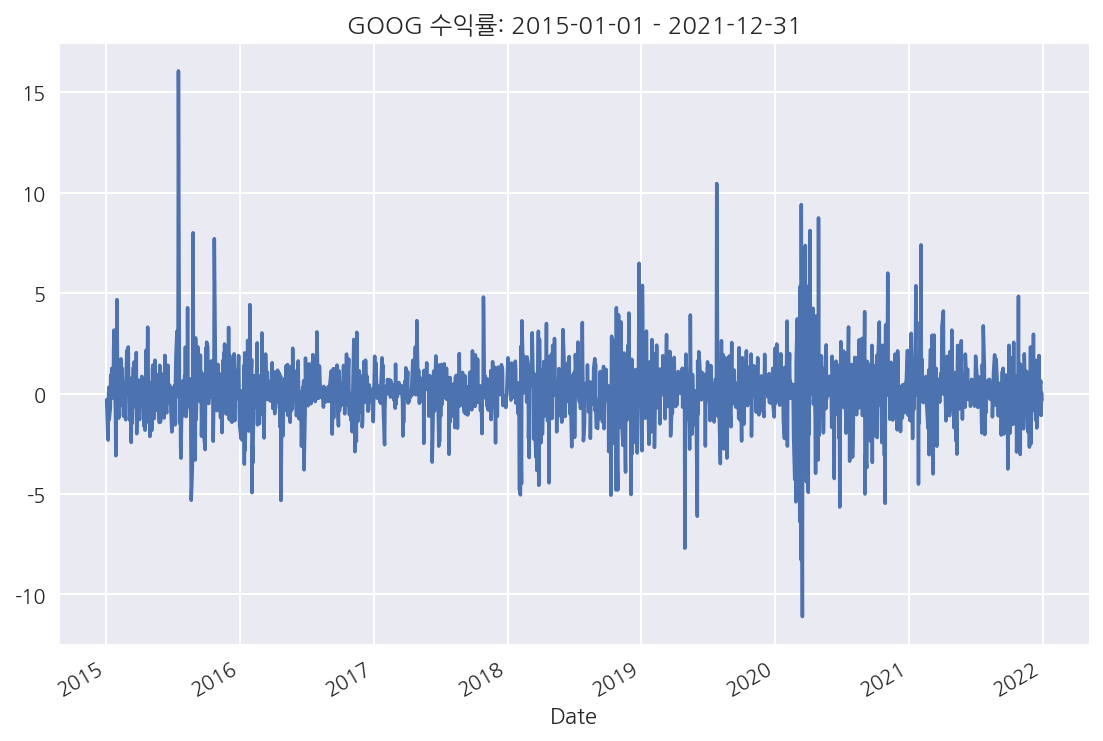

In [8]:
# 일일 수익률 계산
returns = 100 * df["Adj Close"].pct_change().dropna()
returns.name = "asset_returns"

# 평균 수익률 출력
print(f"평균 수익률: {round(returns.mean(), 2)}%")

# 수익률 그래프 그리기
returns.plot(title=f"{RISKY_ASSET} 수익률: {START_DATE} - {END_DATE}");

# 그래프 스타일 조정
sns.despine()  # 상단과 우측 테두리 제거
plt.tight_layout()  # 그래프 레이아웃 최적화

# 그래프 저장 (주석 처리됨)
# plt.savefig("images/figure_9_1", dpi=200)

5. Specify the ARCH model:

**Step 5**: 우리는 **ARCH(1) 모델**을 정의했습니다. 평균 모델로는 여러 유동 자산에 적합한 **제로 평균 접근법**을 선택했습니다. 다른 가능한 선택은 **상수 평균(constant mean)** 일 수 있습니다. 예를 들어, ARMA 모델 대신 이런 방법을 사용할 수 있는데, 이는 수익률 시계열의 자기 상관이 제한적일 수 있기 때문입니다.

In [9]:
# ARCH(1) 모델 정의
# mean="Zero": 평균 모델로 제로 평균 접근법 사용 (수익률의 평균이 0이라고 가정)
# vol="ARCH": 변동성 모델로 ARCH 사용
# p=1: ARCH 모델의 차수를 1로 설정 (ARCH(1) 모델)
# q=0: GARCH 항은 사용하지 않음 (순수 ARCH 모델)
model = arch_model(returns, mean="Zero", vol="ARCH", p=1, q=0)

6. Estimate the model and print the summary:

**Step 6**: 우리는 **fit 메소드**를 사용해 모델을 맞췄습니다. 추가적으로, **fit 메소드** 에 **disp="off"** 를 전달하여 최적화 단계의 출력을 억제했습니다. **arch 라이브러리** 를 사용하여 모델을 맞출 때, 우리는 **scikit-learn 접근법** 과 유사한 단계를 거쳤습니다. 먼저 모델을 정의한 다음 데이터를 맞추는 방식입니다. 하나의 차이점은 **arch** 에서는 모델의 인스턴스를 만들 때 데이터를 제공해야 했다는 점입니다. 반면 **scikit-learn** 에서는 데이터를 **fit 메소드** 에 전달하면 됩니다. 그 후, **summary 메소드** 를 사용해 모델의 요약 결과를 출력했습니다.

In [10]:
# ARCH(1) 모델을 데이터에 맞춥니다
fitted_model = model.fit(disp="off")

# disp="off"는 최적화 과정의 상세 출력을 억제합니다

# 모델 요약 정보를 출력합니다
# 이는 모델 파라미터, 표준 오차, p-값 등의 중요한 통계 정보를 포함합니다
print(fitted_model.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -3302.92
Distribution:                  Normal   AIC:                           6609.85
Method:            Maximum Likelihood   BIC:                           6620.80
                                        No. Observations:                 1762
Date:                Tue, Oct 08 2024   Df Residuals:                     1762
Time:                        07:26:45   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.8625      0.166     11.248  2.360e-29 [  1.538,  2.18

1. **Log-Likelihood**: **-3302.92**  
   - **의미**: 모델의 적합도를 나타내는 지표입니다. 값이 클수록(즉, 0에 가까울수록) 모델이 데이터에 더 잘 맞습니다.
   - **평가**: 로그우도 값이 매우 작은 편이므로, 모델이 데이터를 충분히 잘 설명하지 못할 가능성이 있습니다.

2. **AIC (Akaike Information Criterion)**: **6609.85**  
   - **의미**: 모델의 복잡성과 적합도 간의 균형을 평가하는 지표입니다. 값이 낮을수록 좋은 모델입니다.
   - **평가**: 비교할 다른 모델이 있다면, AIC가 더 낮은 모델이 더 적합합니다. AIC 값이 크다는 것은 개선 여지가 있을 수 있음을 의미합니다.

3. **BIC (Bayesian Information Criterion)**: **6620.80**  
   - **의미**: AIC와 비슷하지만, 데이터 포인트가 많을수록 모델의 복잡성을 더 엄격하게 평가합니다.
   - **평가**: BIC 값도 크므로, 단순한 모델로는 데이터의 복잡성을 충분히 반영하지 못했을 수 있습니다.

4. **omega (ω)**: **1.8625**  
   - **의미**: 기본 변동성(상수 항)을 나타냅니다. 주가 변동성의 기본적인 수준을 의미합니다.
   - **평가**: 값이 양수이고 통계적으로 매우 유의미합니다(p값: 2.360e-29). 기본 변동성 수준이 꽤 높은 것으로 평가됩니다.

5. **alpha[1] (α₁)**: **0.3788**  
   - **의미**: 과거 변동성이 현재 변동성에 미치는 영향을 나타냅니다. 값이 클수록 과거 충격이 현재 변동성에 큰 영향을 미칩니다.
   - **평가**: 통계적으로 유의미(p값: 7.421e-04)하며, 과거 변동성이 현재 변동성에 적당히 큰 영향을 미치는 것으로 나타납니다.

- **모델 적합도**: 로그우도, AIC, BIC 값을 고려할 때, 모델의 적합도가 아주 좋지는 않지만, 변동성 자체를 설명하는 데는 유의미한 결과를 제공합니다.
- **파라미터 유의성**: **ω**와 **α₁** 모두 통계적으로 유의미한 값을 가지며, 과거 변동성의 영향이 적절하게 반영된 모델입니다.

7. Plot the residuals and the conditional volatility:

**Step 7**: 우리는 표준화된 잔차와 조건부 변동성 시계열을 플로팅하여 확인했습니다. 표준화된 잔차는 잔차를 조건부 변동성으로 나누어 계산했습니다. 우리는 **annualize="D"** 를 **plot 메소드** 에 전달하여 일일 데이터에서 조건부 변동성을 연간화했습니다.

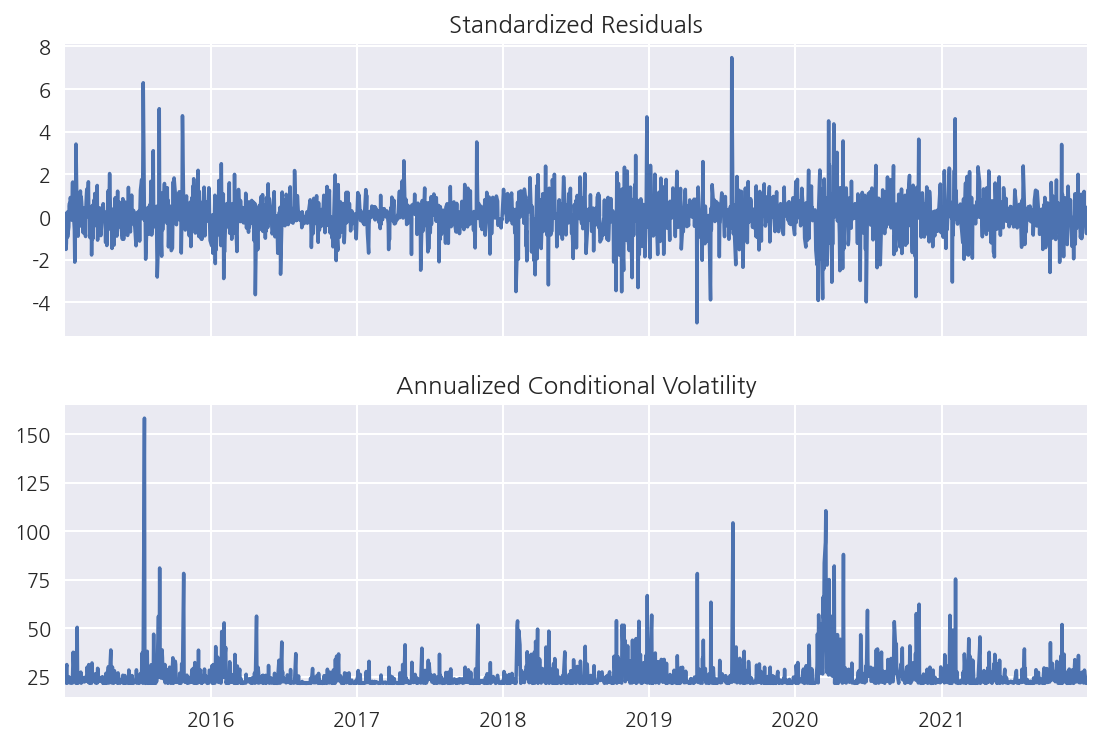

In [11]:
# 맞춘 모델의 결과를 플롯합니다
fitted_model.plot(annualize="D")

# 그래프의 테두리를 제거합니다
sns.despine()

# 그래프의 레이아웃을 조정합니다
plt.tight_layout()

# 그래프를 이미지 파일로 저장하는 코드 (현재는 주석 처리되어 있음)
# plt.savefig("images/figure_9_2", dpi=200)

In the cell below we confirm that the standardized residuals are simply residuals divided by the conditional volatility.

In [12]:
# GARCH 모델 진단을 위한 데이터 준비
diagnostics_dict = {
    "resids": fitted_model.resid,  # 모델의 잔차
    "conditional_volatility": fitted_model.conditional_volatility,  # 조건부 변동성
    "std_resid": fitted_model.std_resid,  # 표준화된 잔차 (모델에서 계산)
    "std_resid_manual": fitted_model.resid / fitted_model.conditional_volatility,  # 수동으로 계산한 표준화된 잔차
}

# 진단 데이터를 DataFrame으로 변환
df_diagnostics = pd.DataFrame(data = diagnostics_dict)

# 진단 결과 출력
df_diagnostics  # 결과를 확인하기 위해 DataFrame을 반환합니다

,resids,conditional_volatility,std_resid,std_resid_manual
Date,,,,
2015-01-02,-0.302052,1.644876,-0.183632,-0.183632
2015-01-05,-2.084566,1.377349,-1.513462,-1.513462
2015-01-06,-2.317708,1.873083,-1.237376,-1.237376
2015-01-07,-0.171316,1.974131,-0.086781,-0.086781
2015-01-08,0.315297,1.368813,0.230344,0.230344
...,...,...,...,...
2021-12-23,0.131677,1.793944,0.073401,0.073401
2021-12-27,0.626259,1.367151,0.458076,0.458076
2021-12-28,-1.091412,1.418128,-0.769615,-0.769615


### There's more

ARCH 모델에 대한 몇 가지 중요한 사항을 추가로 설명합니다:

- **제로 평균 프로세스 선택**은 별도로 추정된 모델에서 잔차를 처리할 때 유용합니다.
  
- **ARCH 효과를 탐지하기 위해** 특정 모델(예: ARIMA 모델)의 잔차 제곱의 상관도를 확인할 수 있습니다. 이 잔차들의 평균이 0인지 확인해야 합니다. **부분 자기상관 함수(PACF)** 플롯을 사용하여 **q** 값을 추론할 수 있습니다. 이는 AR 모델의 경우와 유사한 접근 방식입니다(자세한 내용은 **ARIMA 클래스 모델을 사용한 시계열 모델링**을 참조하세요).

- **모델의 유효성을 테스트하기 위해**, 표준화된 잔차와 제곱된 표준화 잔차가 시계열적 자기상관을 보이지 않는지 확인할 수 있습니다. 이를 위해 **statsmodels**의 **corr_ljungbox** 함수를 사용하여 **Ljung-Box** 또는 **Box-Pierce** 테스트를 수행할 수 있습니다. 또는, **LM 테스트(Lagrange Multiplier test)** 를 사용하여 모든 ARCH 효과가 모델에 캡처되었는지 확인할 수 있습니다. 이를 위해 **statsmodels**의 **het_arch** 함수를 사용할 수 있습니다.

다음 코드 조각에서는 ARCH 모델의 잔차를 LM 테스트로 검사합니다.

Test the residuals of the ARCH(1) model with the LM test.

In [13]:
from statsmodels.stats.diagnostic import het_arch
het_arch(fitted_model.resid)

(98.10943851287608,
 1.3014936006683629e-16,
 10.327680466193117,
 4.2120987625006956e-17)

As the residuals come from a model in which we estimated two parameters (omega and alpha), we should correct for that when using the `het_arch` test.

In [14]:
het_arch(fitted_model.resid, ddof=2)

(97.99744143694814,
 1.3703129580896425e-16,
 10.327680466193117,
 4.2120987625006956e-17)

첫 번째 두 값은 LM 테스트 통계량과 그에 해당하는 p-값입니다. 마지막 두 값은 F 테스트에 대한 f-통계량(ARCH 효과를 테스트하는 대체 접근법)과 그에 해당하는 p-값입니다. 두 p-값 모두 일반적인 유의 수준인 0.05 이하임을 확인할 수 있습니다. 이는 잔차가 **동분산적(homoskedastic)** 이라는 귀무 가설을 기각하게 함을 의미합니다. 즉, **ARCH(1) 모델** 이 잔차에서 모든 ARCH 효과를 포착하지 못했다는 것을 나타냅니다.

**het_arch 함수** 의 문서에 따르면, 잔차가 회귀 모델에서 나오는 경우 해당 모델의 추정된 파라미터 수에 대한 보정을 해야 합니다. 예를 들어, 잔차가 **ARMA(2,1)**  모델에서 나왔다면, **het_arch 함수** 에 **ddof = 3** 이라는 추가 인자를 전달해야 합니다. 여기서 **ddof** 는 자유도를 의미합니다.

### See also:

추가 리소스는 다음에서 확인할 수 있습니다:
- Engle, R. F. 1982., "Autoregressive conditional heteroscedasticity with estimates of the variance of United Kingdom inflation," *Econometrica*, 50(4): 987-1007.

## 9.2 Modeling stock returns' volatility with GARCH models

**GARCH 모델을 사용한 주식 수익률 변동성 모델링**

이 항목에서는 ARCH 모델의 확장인 일반화 자기회귀 조건부 이분산(GARCH, Generalized Autoregressive Conditional Heteroskedasticity) 모델을 사용하는 방법을 설명합니다. GARCH는 시계열 분산에 적용되는 ARMA 모델로 간주될 수 있습니다. AR(자기회귀) 구성 요소는 이미 ARCH 모델에서 표현되었으며, GARCH는 이동 평균 부분을 추가합니다.

GARCH 모델의 방정식은 다음과 같이 표현될 수 있습니다:

$
r_t = \mu + \epsilon_t
$

$
\epsilon_t = \sigma_t z_t
$

$
\sigma_t^2 = \omega + \sum_{i=1}^{q} \alpha_i \epsilon_{t-1}^2 + \sum_{i=1}^{p} \beta_i \sigma_{t-1}^2
$

이 방정식의 해석은 이전 항목에서 제시된 ARCH 모델과 매우 유사하지만, 마지막 방정식에서 추가적인 구성 요소를 볼 수 있습니다. 매개변수는 다음 조건을 충족해야 합니다: $\omega > 0$, $\alpha_i \geq 0$, 그리고 $\beta_i \geq 0$.

>GARCH 모델에서는 계수에 대한 추가적인 제약이 있습니다. 예를 들어, GARCH(1,1) 모델의 경우 $\alpha_i + \beta_i$는 1보다 작아야 합니다. 그렇지 않으면 모델이 불안정해집니다.

GARCH 모델의 두 하이퍼파라미터는 다음과 같이 설명될 수 있습니다:
- **p**: 지연된 분산의 수
- **q**: 평균 프로세스에서 지연된 잔차 오류의 수


>GARCH(0, q) 모델은 ARCH(q) 모델과 동등하다

ARCH/GARCH 모델의 지연 차수를 추론하는 한 가지 방법은 원래 시계열의 평균을 예측하는 데 사용된 모델에서 제곱된 잔차를 사용하는 것입니다. 잔차는 0을 중심으로 하며, 이들의 제곱은 분산에 해당합니다. 우리는 제곱된 잔차의 ACF(자기상관 함수) 및 PACF(부분 자기상관 함수) 플롯을 검사하여 시계열 분산의 자기상관 패턴을 식별할 수 있습니다 (마치 ARMA/ARIMA 모델의 차수를 식별하는 것과 유사하게).

일반적으로, GARCH 모델은 ARCH 모델의 강점과 약점을 공유하지만, 과거 충격의 영향을 더 잘 포착하는 차이가 있습니다. GARCH 모델의 확장에 대해 알고 싶다면 "더 읽어보세요(There’s more…)" 섹션을 참고하여 원래 모델의 단점을 보완한 내용을 확인할 수 있습니다.

이 항목에서는 이전 항목과 동일한 데이터에 GARCH(1,1) 모델을 적용하여 두 가지 모델링 접근 방식의 차이를 명확하게 강조하려고 합니다.

### How to do it...

이 레시피에서는 ARCH 및 GARCH 모델의 결과를 비교하기 위해 이전과 동일한 데이터를 사용했습니다. 데이터를 다운로드하는 방법에 대한 자세한 내용은 **Modeling stock returns' volatility with ARCH models** 레시피의 1단계부터 4단계를 참조하세요.

`arch` 라이브러리의 편리함 덕분에 이전에 사용된 코드를 쉽게 조정하여 ARCH 모델에 맞출 수 있었습니다. GARCH 모델을 추정하기 위해서는 사용할 변동성 모델 유형을 지정하고 추가 인수로 `q=1`을 설정해야 했습니다.

비교를 위해 평균 과정을 제로-평균 과정으로 남겨두었습니다.

1. Specify the GARCH model:

In [18]:
model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

2. Estimate the model and print the summary:

In [16]:
fitted_model = model.fit(disp="off")
print(fitted_model.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -3246.71
Distribution:                  Normal   AIC:                           6499.42
Method:            Maximum Likelihood   BIC:                           6515.84
                                        No. Observations:                 1762
Date:                Tue, Oct 08 2024   Df Residuals:                     1762
Time:                        07:26:53   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2864      0.186      1.539      0.124 [-7.84

**모델 결과 요약 (Zero Mean - GARCH Model Results)**:
   - **종속 변수(Dep. Variable)**: `asset_returns`, 즉 자산 수익률을 종속 변수로 설정했습니다.
   - **평균 모델**: Zero Mean, 즉 평균이 0인 모델을 사용했습니다.
   - **변동성 모델(Vol Model)**: GARCH 모델을 사용했습니다.
   - **분포(Distribution)**: 정규 분포(Normal)를 사용했습니다.
   - **로그 가능도(Log-Likelihood)**: -3246.71로, 모델이 데이터를 얼마나 잘 설명하는지를 나타냅니다. 이 값이 높을수록(덜 음수일수록) 모델이 데이터를 더 잘 설명하는 것입니다.
   - **AIC**와 **BIC**: 각각 6499.42와 6515.84로, 모델의 적합성을 평가하는 지표입니다. AIC와 BIC는 낮을수록 좋은 모델로 간주됩니다.
   - **추정된 매개변수(coef)**: 각각의 값에 대한 표준 오차와 t값, 그리고 p-값이 제공되며, 이는 각 매개변수가 유의한지 여부를 판단하는 데 사용됩니다. 여기서 `alpha`와 `beta`는 GARCH 모델의 주요 매개변수로, 과거의 변동성과 상관관계를 나타냅니다.
     - **omega**: 0.2864
     - **alpha[1]**: 0.1697
     - **beta[1]**: 0.7346 
   - **공분산 추정치(Covariance estimator)**: 'robust'로 설정되어 있어 강건한 공분산 추정치를 사용했습니다.

**Market Risk Analysis**에 따르면, 안정된 시장에서 매개변수 값의 일반적인 범위는 $0.05 < \alpha < 0.01$ 및 $0.85 < \beta < 0.98$입니다. 그러나 이러한 범위가 엄격히 적용되지는 않겠지만, 우리가 예상해야 할 값의 범위에 대한 아이디어를 어느 정도 제공해 준다는 점을 기억해야 합니다.

ARCH 모델과 비교했을 때, 로그 가능도가 증가했으며, 이는 GARCH 모델이 데이터를 더 잘 맞춘다는 것을 의미합니다. 하지만 이러한 결론을 내릴 때는 주의해야 합니다. 로그 가능도는 더 많은 예측 변수를 추가할 때마다(우리가 GARCH와 함께 한 것처럼) 증가할 가능성이 큽니다. 예측 변수의 수가 변경될 경우, 두 중첩된 회귀 모델의 적합도를 비교하기 위해 우도비 검정을 실행해야 합니다.
   - 이 모델에서 추정된 `alpha[1]`와 `beta[1]` 값을 보면, 이들이 각각 0.1697과 0.7346로, 안정적인 시장 범위에 들어맞지 않음을 알 수 있습니다.



3. Plot the residuals and the conditional volatility:

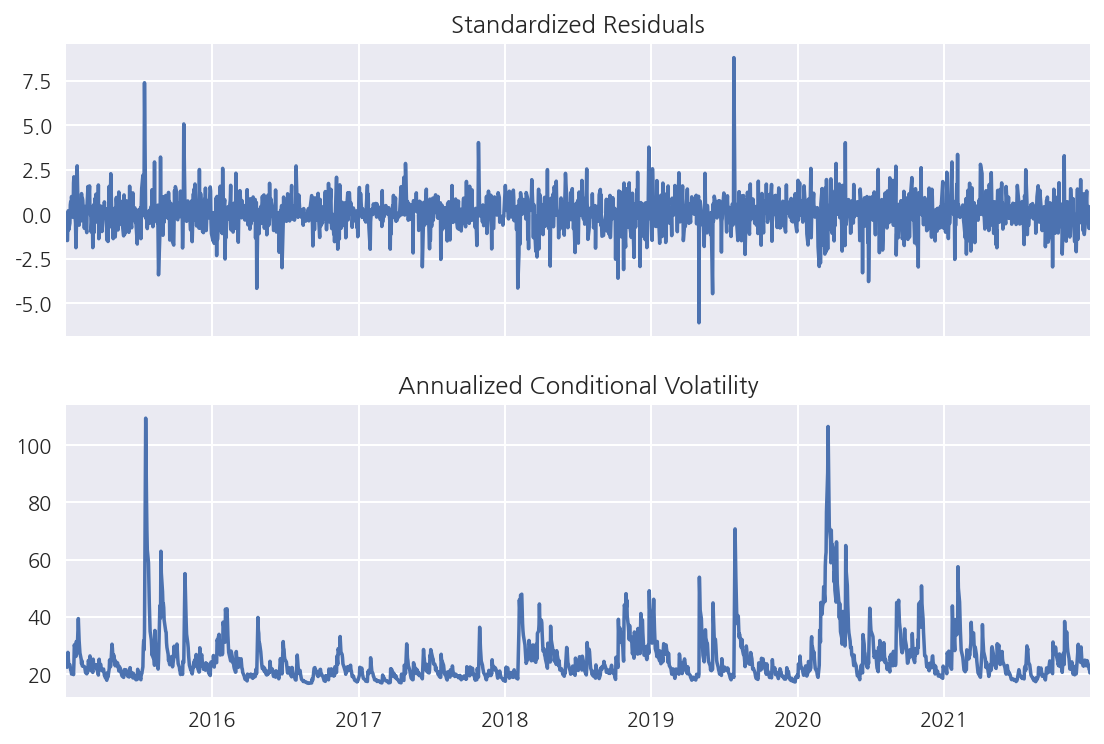

In [17]:
fitted_model.plot(annualize="D")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_3", dpi=200)

ARCH를 사용할 때, 조건부 변동성 시계열은 많은 스파이크를 보이며, 그 후 바로 낮은 수준으로 돌아갑니다. GARCH의 경우, 모델이 지연된 조건부 변동성도 포함하기 때문에 스파이크 이전 수준으로 돌아가는 데 더 많은 시간이 걸립니다.

### There’s more...

이 챕터에서 우리는 두 가지 모델을 사용하여 시계열의 조건부 변동성을 설명하고 잠재적으로 예측하는 방법을 이미 다루었습니다. 그러나 GARCH 모델의 다양한 확장, 그리고 최적의 모델을 찾기 위해 실험할 수 있는 여러 구성도 존재합니다.

GARCH 프레임워크에서는 하이퍼파라미터(예: $p$ 및 $q$와 같은 변수 GARCH 모델) 외에도 아래에 설명된 모델을 수정할 수 있습니다.

**조건부 평균 모델**

앞에서 설명한 것처럼, 우리는 다른 모델을 시계열에 맞춘 후에 얻은 잔차에 GARCH 클래스 모델을 적용합니다. 평균 모델로 사용할 수 있는 몇 가지 인기 있는 선택은 다음과 같습니다:

- 제로-평균
- 상수 평균
- ARIMA 모델의 변형(계절 조정 및 외부 설명 변수를 포함한 잠재적인 조정 가능) — 문헌에서 인기 있는 선택은 ARMA 또는 AR 모델입니다
- 회귀 모델

**우리는 조건부 평균을 모델링할 때 몇 가지 사항을 유념해야 합니다.** 예를 들어, 먼저 ARMA 모델을 시계열에 맞춘 다음 첫 번째 모델의 잔차에 GARCH 모델을 맞출 수 있습니다. 하지만 이것은 선호되는 방법이 아닙니다. 이는 일반적으로 ARMA 추정치가 일관되지 않거나(일관되지만 비효율적일 수 있음) 영향을 미칠 수 있기 때문입니다. 이는 첫 번째 모델(ARMA/ARIMA)이 조건부 동분산성을 가정하고, GARCH 모델은 조건부 이분산성을 명시적으로 모델링하기 때문입니다. 그래서 두 모델을 동시에 추정하는 것이 선호되는 방식입니다. 예를 들어, `arch` 라이브러리(또는 R의 `rugarch` 패키지)를 사용할 수 있습니다.


**조건부 변동성 모델**

GARCH 프레임워크에 대한 많은 확장이 존재합니다. 다음은 인기 있는 모델들입니다:

- **GJR-GARCH**: GARCH 모델의 변형으로, 수익의 비대칭성을 고려합니다(음의 수익이 양의 수익보다 변동성에 더 큰 영향을 미치는 경향이 있음).
- **EGARCH**: 지수 GARCH
- **TGARCH**: 임계값 GARCH
- **FIGARCH**: 부분적으로 통합된 GARCH, 비정상적인 데이터를 사용
- **GARCH-MIDAS**: 이 클래스의 모델에서 변동성은 단기 GARCH 구성 요소와 설명 변수에 의해 구동되는 장기 구성 요소로 분해됩니다.
- **다변량 GARCH 모델**: CCC/DCC-GARCH와 같은 모델

처음 세 모델은 조건부 변동성 명세에 비대칭성을 도입하는 약간 다른 접근 방식을 사용합니다. 이는 음의 충격이 양의 충격보다 변동성에 더 큰 영향을 미친다는 믿음과 일치합니다.

**오차의 분포**

**Investigating stylized facts of asset returns** 레시피에서는 수익 분포가 정규 분포가 아님을 확인했습니다(왜곡되어 있으며 무거운 꼬리를 가짐). 그래서 GARCH 모델에 대한 오류를 수정할 때는 정규 분포보다 더 나은 분포가 있을 수 있습니다.

다음은 몇 가지 가능한 선택입니다:

- 학생-t 분포
- 왜곡-t 분포(Hansen, 1994)
- 일반화 오차 분포(GED)
- **Skewed Generalized Error Distribution (SGED)**

**arch** 라이브러리는 위에서 언급한 대부분의 모델과 분포를 제공할 뿐만 아니라, 사전 정의된 형식에 맞는 경우 사용자가 자신의 변동성 모델/오차 분포를 사용할 수 있는 기능도 제공합니다. 이에 대한 더 자세한 내용은 우수한 문서를 참조하십시오.


### Sea also

추가 자료는 다음에서 확인할 수 있습니다:

- Alexander, C. 2008. *Market Risk Analysis, Practical Financial Econometrics* (Vol. 2). John Wiley & Sons.
- Bollerslev, T., 1986. “Generalized Autoregressive Conditional Heteroskedasticity.” *Journal of Econometrics*, 31, (3): 307–327. [링크](https://doi.org/10.1016/0304-4076(86)90063-1)
- Glosten, L. R., Jagannathan, R., and Runkle, D. E., 1993. “On the relation between the expected value and the volatility of the nominal excess return on stocks.” *The Journal of Finance*, 48 (5): 1779–1801. [링크](https://doi.org/10.1111/j.1540-6261.1993.tb05128.x)
- Hansen, B. E., 1994. “Autoregressive conditional density estimation.” *International Economic Review*, 35(3): 705–730. [링크](https://doi.org/10.2307/2527081)
- **arch** 라이브러리의 문서화: [링크](https://arch.readthedocs.io/en/latest/index.html)

## 9.3 Forecasting volatility using GARCH models


**GARCH 모델을 사용한 변동성 예측**

이전의 레시피에서 우리는 수익 시리즈에 ARCH/GARCH 모델을 적합시키는 방법을 보았습니다. 하지만 ARCH 계열 모델을 사용할 때 가장 흥미롭고 관련성 있는 경우는 미래 변동성 값을 예측하는 것입니다.

GARCH 계열 모델을 사용한 변동성 예측에는 세 가지 접근 방식이 있습니다:

- **분석적 방법** — ARCH 계열 모델의 고유한 구조로 인해, 분석적 예측은 항상 한 단계 앞서 예측할 수 있습니다. 다단계 분석적 예측은 잔차 제곱에 대해 선형적인 모델(예: GARCH 또는 이질적 ARCH)에서만 가능하지만, 전진 재귀를 사용하여 예측을 얻을 수 있습니다.

- **시뮬레이션** — 시뮬레이션 기반 예측은 ARCH 계열 모델의 구조를 사용하여 잔차의 가정된 분포를 기반으로 가능한 변동성 경로를 시뮬레이션합니다. 즉, 특정 분포를 가정하여 난수 생성기를 사용하여 표준화된 잔차를 도출합니다. 이 접근 방식은 x개의 가능한 변동성 경로를 생성하고, 그 평균을 최종 예측으로 제공합니다. 시뮬레이션 기반 예측은 언제든지 사용할 수 있으며, 시뮬레이션 횟수가 무한대로 증가하면 시뮬레이션 기반 예측은 분석적 예측에 수렴합니다.

- **부트스트랩(필터링된 역사적 시뮬레이션으로도 알려져 있음)** — 이 예측은 시뮬레이션 기반 예측과 매우 유사하지만, 실제 입력 데이터와 추정된 매개변수를 사용하여 표준화된 잔차를 추출(정확히는 복원 추출)한다는 점에서 다릅니다. 이 접근 방식은 예측을 생성하기 위해 사용할 소량의 표본 내 데이터를 필요로 합니다.

>ARCH 계열 모델의 특성상, 첫 번째 샘플 외 예측은 우리가 사용하는 접근 방식에 관계없이 항상 고정됩니다.

이 레시피에서는 Microsoft의 2015년부터 2020년까지의 주가 수익률에 Student의 t 분포를 따르는 잔차를 사용하여 GARCH(1,1) 모델을 적합시킵니다. 그런 다음 2021년의 각 날에 대한 3단계 앞선 예측을 생성합니다.

### How to do it...

1. Import the libraries:

In [6]:
import pandas as pd
import yfinance as yf
from datetime import datetime
from arch import arch_model

2. Download data from Yahoo Finance and calculate simple returns:

첫 번째와 두 번째 단계에서는 필수 라이브러리를 불러오고 2015년부터 2021년까지의 Microsoft 주가를 다운로드합니다. 수익률을 계산하고, 최적화 중 발생할 수 있는 수렴 문제를 피하기 위해 값에 100을 곱합니다.

In [7]:
# Yahoo Finance에서 Microsoft(MSFT) 주식 데이터 다운로드
df = yf.download("MSFT",
                 start="2015-01-01",  # 시작 날짜
                 end="2021-12-31")    # 종료 날짜

# 일일 수익률 계산
# 1. df["Adj Close"].pct_change()로 수정 종가의 변화율 계산
# 2. 100을 곱해 퍼센트로 변환
# 3. dropna()로 결측값 제거 (첫 날의 수익률은 계산할 수 없으므로 NaN이 됨)
returns = 100 * df["Adj Close"].pct_change().dropna()

# 결과 시리즈의 이름을 "asset_returns"으로 지정
returns.name = "asset_returns"

[*********************100%***********************]  1 of 1 completed


3. Specify the GARCH model:

**Step 3**에서는 GARCH 모델을 지정합니다. 즉, 학생 t 분포를 따르는 잔차를 가진 평균 0인 GARCH(1, 1) 모델입니다.

In [8]:
# GARCH 모델 정의
model = arch_model(
    returns,        # 수익률 데이터
    mean="Zero",    # 평균 모델: 0으로 설정 (수익률의 평균이 0이라고 가정)
    vol="GARCH",    # 변동성 모델: GARCH 사용
    dist="t",       # 오차항 분포: 학생 t 분포 사용 (두꺼운 꼬리 분포를 잘 포착)
    p=1,            # GARCH 모델의 자기회귀(AR) 항의 차수
    q=1             # GARCH 모델의 이동평균(MA) 항의 차수
)

4. Define the split date and fit the model:

**Step 4**에서는 훈련 세트와 테스트 세트를 나누기 위해 사용된 날짜 객체(`datetime` 객체)를 정의합니다. 그런 다음 `fit` 메서드를 사용하여 모델을 적합시킵니다. 이번에는 훈련 세트가 종료되는 시점을 나타내기 위해 `last_obs` 인수를 지정합니다. 우리는 `datetime(2021, 1, 1)` 값을 사용하며, 이는 실제로 훈련에 사용되는 마지막 관찰 값이 2020년 12월의 마지막 날짜임을 의미합니다.

In [9]:
# 훈련 세트와 테스트 세트를 나누는 기준 날짜 설정
# 2021년 1월 1일을 기준으로 이전 데이터는 훈련에 사용되고, 이후 데이터는 테스트에 사용됩니다.
SPLIT_DATE = datetime(2021, 1, 1)

# GARCH 모델 적합
# last_obs: SPLIT_DATE까지의 데이터만 사용하여 모델을 훈련시킵니다.
# disp="off": 최적화 과정의 상세 정보를 출력하지 않습니다.
fitted_model = model.fit(last_obs=SPLIT_DATE, disp="off")

5. Create and inspect the analytical forecasts:

**Step 5**에서는 적합된 GARCH 모델을 사용해 `forecast` 메서드를 통해 분석 예측을 생성합니다. 예측 기간과 시작 날짜(훈련 중 제공된 `last_obs`와 동일한 값)를 지정한 다음, 각 기간에 대한 예측을 시각화합니다.

일반적으로 `forecast` 메서드를 사용하면 4개의 주요 속성을 가진 **ARCHModelForecast** 객체가 반환되며, 유용한 정보는 다음과 같습니다:

- **mean**: 조건부 평균의 예측
- **variance**: 조건부 분산의 예측
- **residual_variance**: 잔차 분산의 예측. 이 값은 모델이 평균 동적성을 갖는 경우(예: AR 프로세스) 분산에 저장된 값과 다를 수 있습니다.
- **simulations**: 예측 생성을 위해 사용된 개별 시뮬레이션(시뮬레이션 및 부트스트랩 접근법에만 해당) 객체

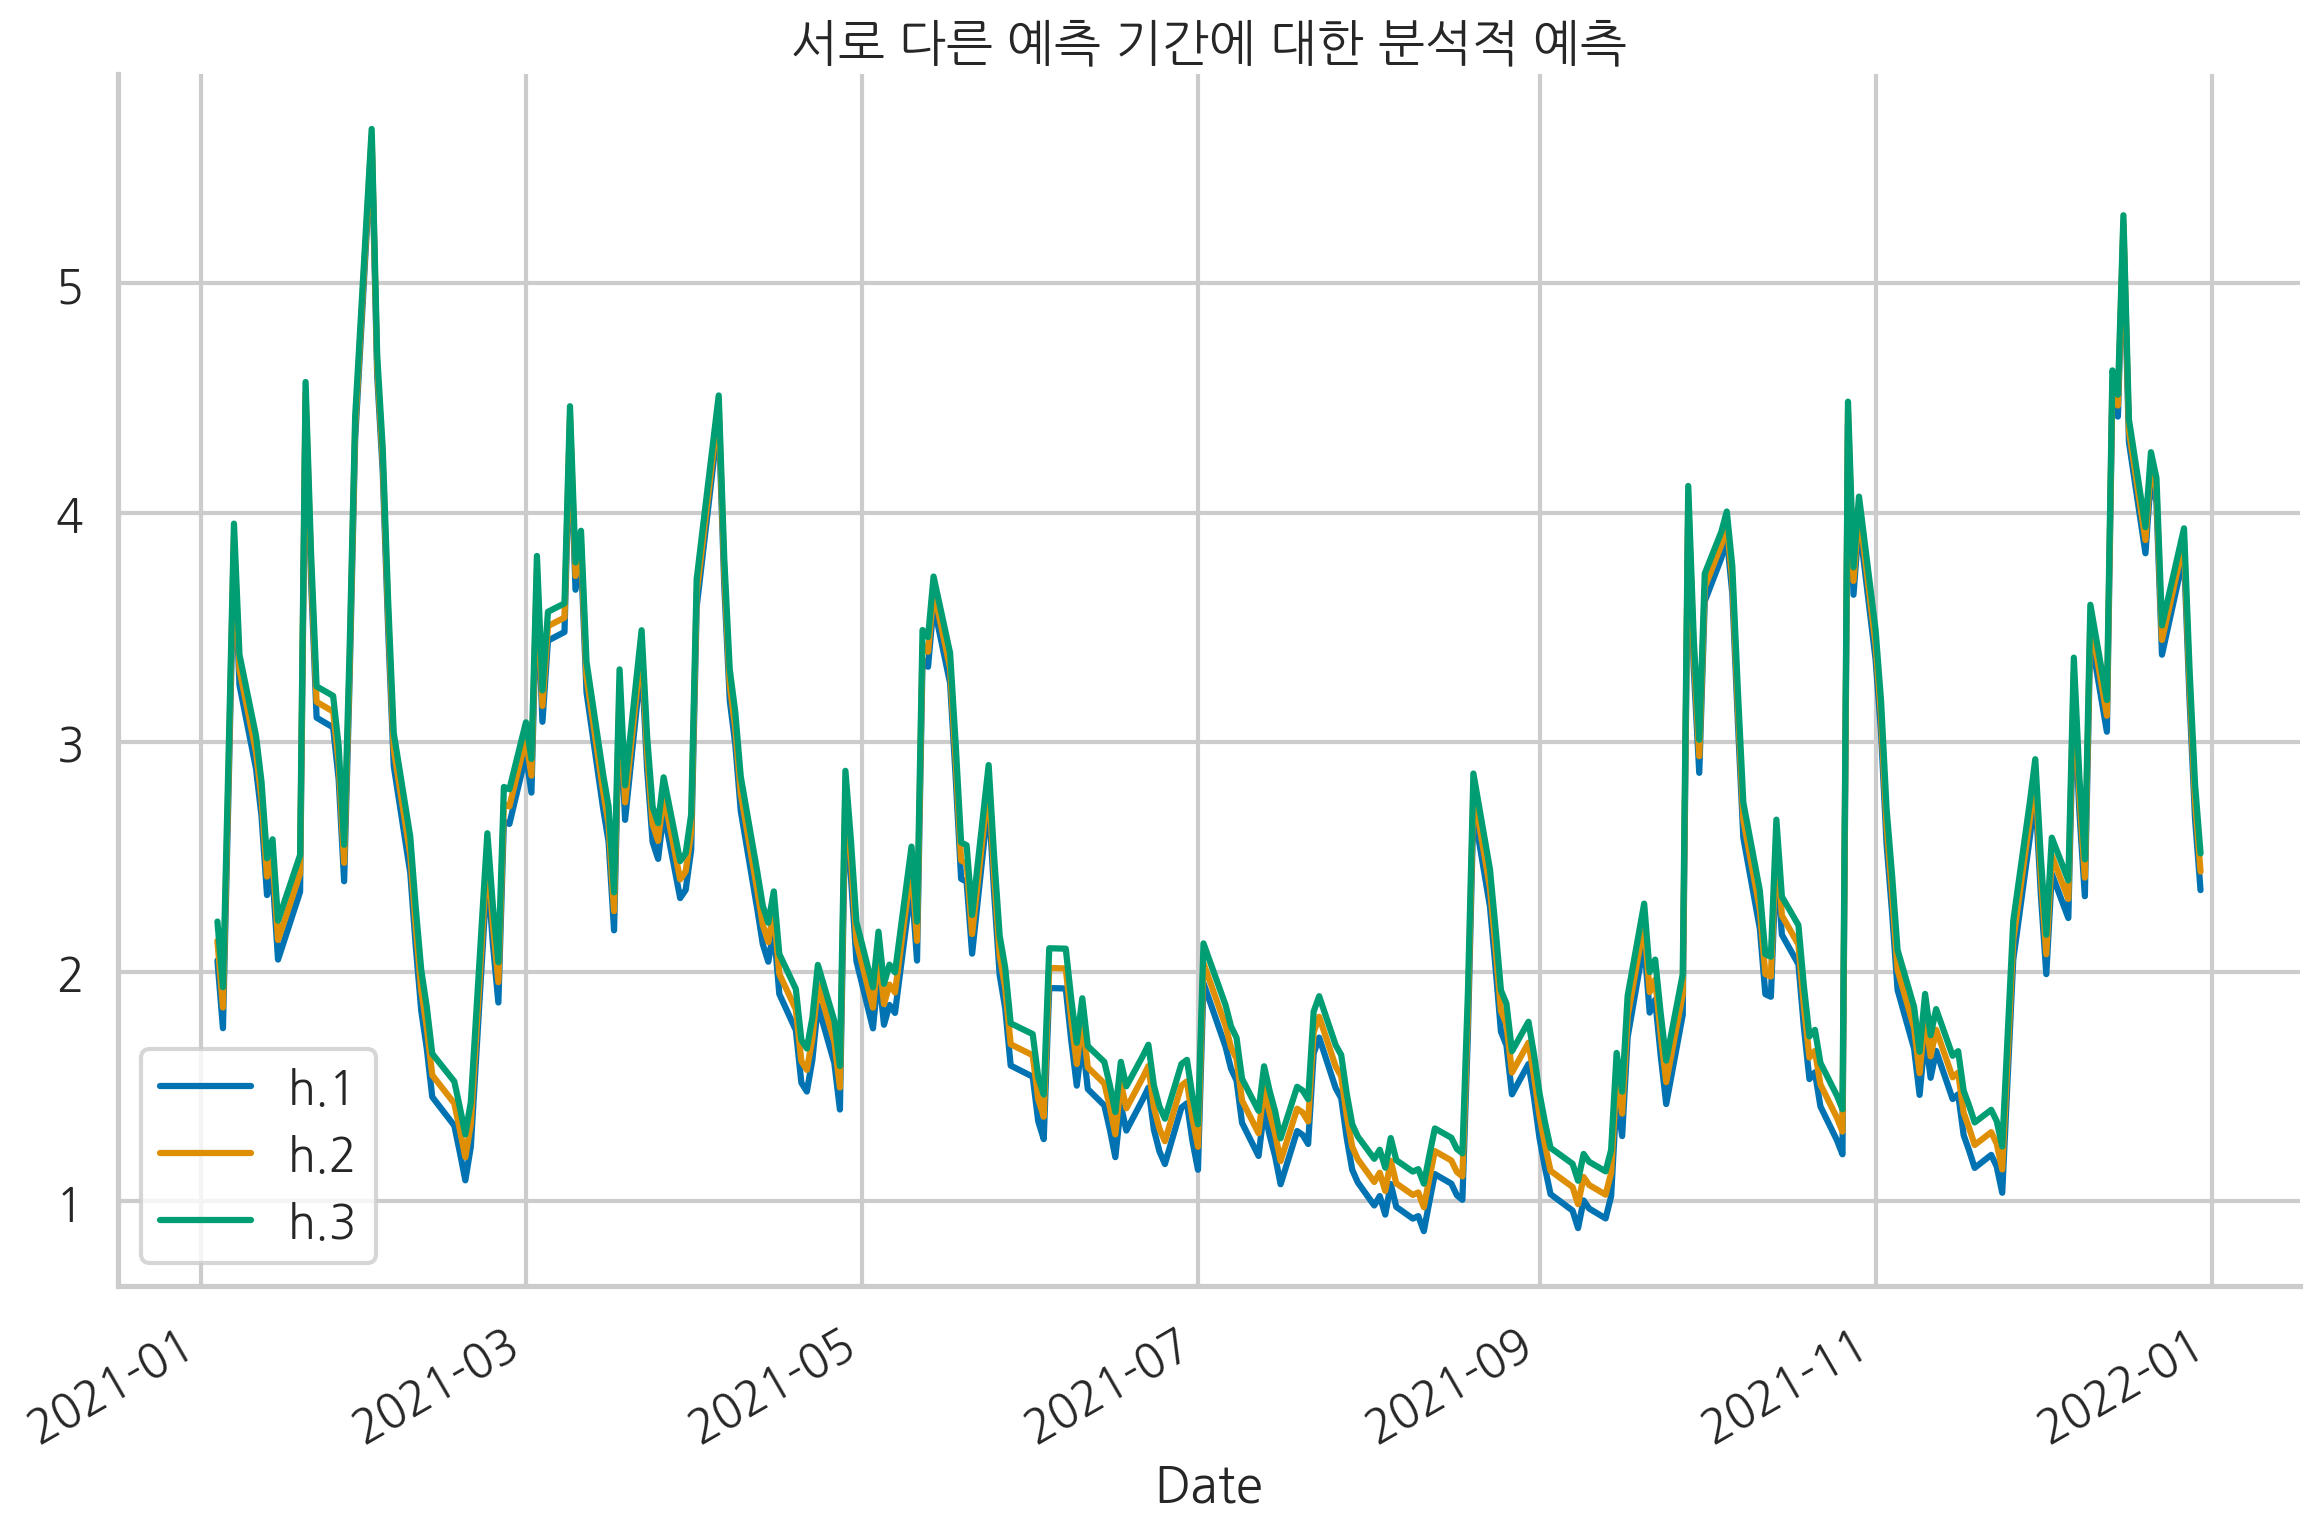

In [27]:
# GARCH 모델을 사용하여 분석적 예측 생성
# 3일 앞을 예측하고, 예측 시작일은 SPLIT_DATE로 설정합니다.
# reindex=False로 설정하여 원본 인덱스를 유지합니다.
forecasts_analytical = fitted_model.forecast(horizon=3,
                                             start=SPLIT_DATE,
                                             reindex=False)

# 예측된 변동성을 시각화합니다.
# variance 속성을 사용하여 예측된 분산(변동성의 제곱)을 플롯합니다.
forecasts_analytical.variance.plot(
    title="서로 다른 예측 기간에 대한 분석적 예측"
)

# 그래프 스타일을 조정합니다.
sns.despine()  # 상단과 우측 테두리를 제거하여 그래프를 깔끔하게 만듭니다.
plt.tight_layout()  # 그래프 레이아웃을 최적화하여 모든 요소가 잘 보이도록 합니다.

# 그래프를 파일로 저장합니다. (현재는 주석 처리되어 있어 실행되지 않습니다)
# 필요한 경우 주석을 해제하여 그래프를 이미지 파일로 저장할 수 있습니다.
# plt.savefig("images/figure_9_4", dpi=200)

In [28]:
forecasts_analytical.variance

,h.1,h.2,h.3
Date,,,
2021-01-04,2.048970,2.134427,2.218528
2021-01-05,1.754038,1.844173,1.932878
2021-01-06,2.770909,2.844915,2.917747
2021-01-07,3.838416,3.895490,3.951659
2021-01-08,3.248873,3.315298,3.380669
...,...,...,...
2021-12-23,3.380792,3.445124,3.508437
2021-12-27,3.817191,3.874602,3.931102
2021-12-28,3.185615,3.253043,3.319402


각 열에는 인덱스로 표시된 날짜에 생성된 h-단계 앞 예측이 포함되어 있습니다. 예측이 생성될 때, **Date** 열의 날짜는 예측을 생성하는 데 사용된 마지막 데이터 포인트에 해당합니다. 예를 들어, 2021년 1월 8일이 있는 열에는 1월 9일, 10일, 11일에 대한 예측이 포함되어 있습니다. 이 예측은 1월 8일까지의 데이터를 사용하여 생성되었습니다.

6. Create and inspect the simulation forecasts:

**Step 6**과 **Step 7**에서는 시뮬레이션 및 부트스트랩 방법을 사용하여 유사한 3단계 앞의 예측을 생성합니다. 우리는 `forecast` 메서드에 있는 선택적 `method` 인수를 추가하여 사용하고 싶은 예측 방법을 지정합니다. 기본적으로, 이 방법들은 예측을 생성하기 위해 1,000번의 시뮬레이션을 사용하지만, 이 수치는 자유롭게 변경할 수 있습니다.


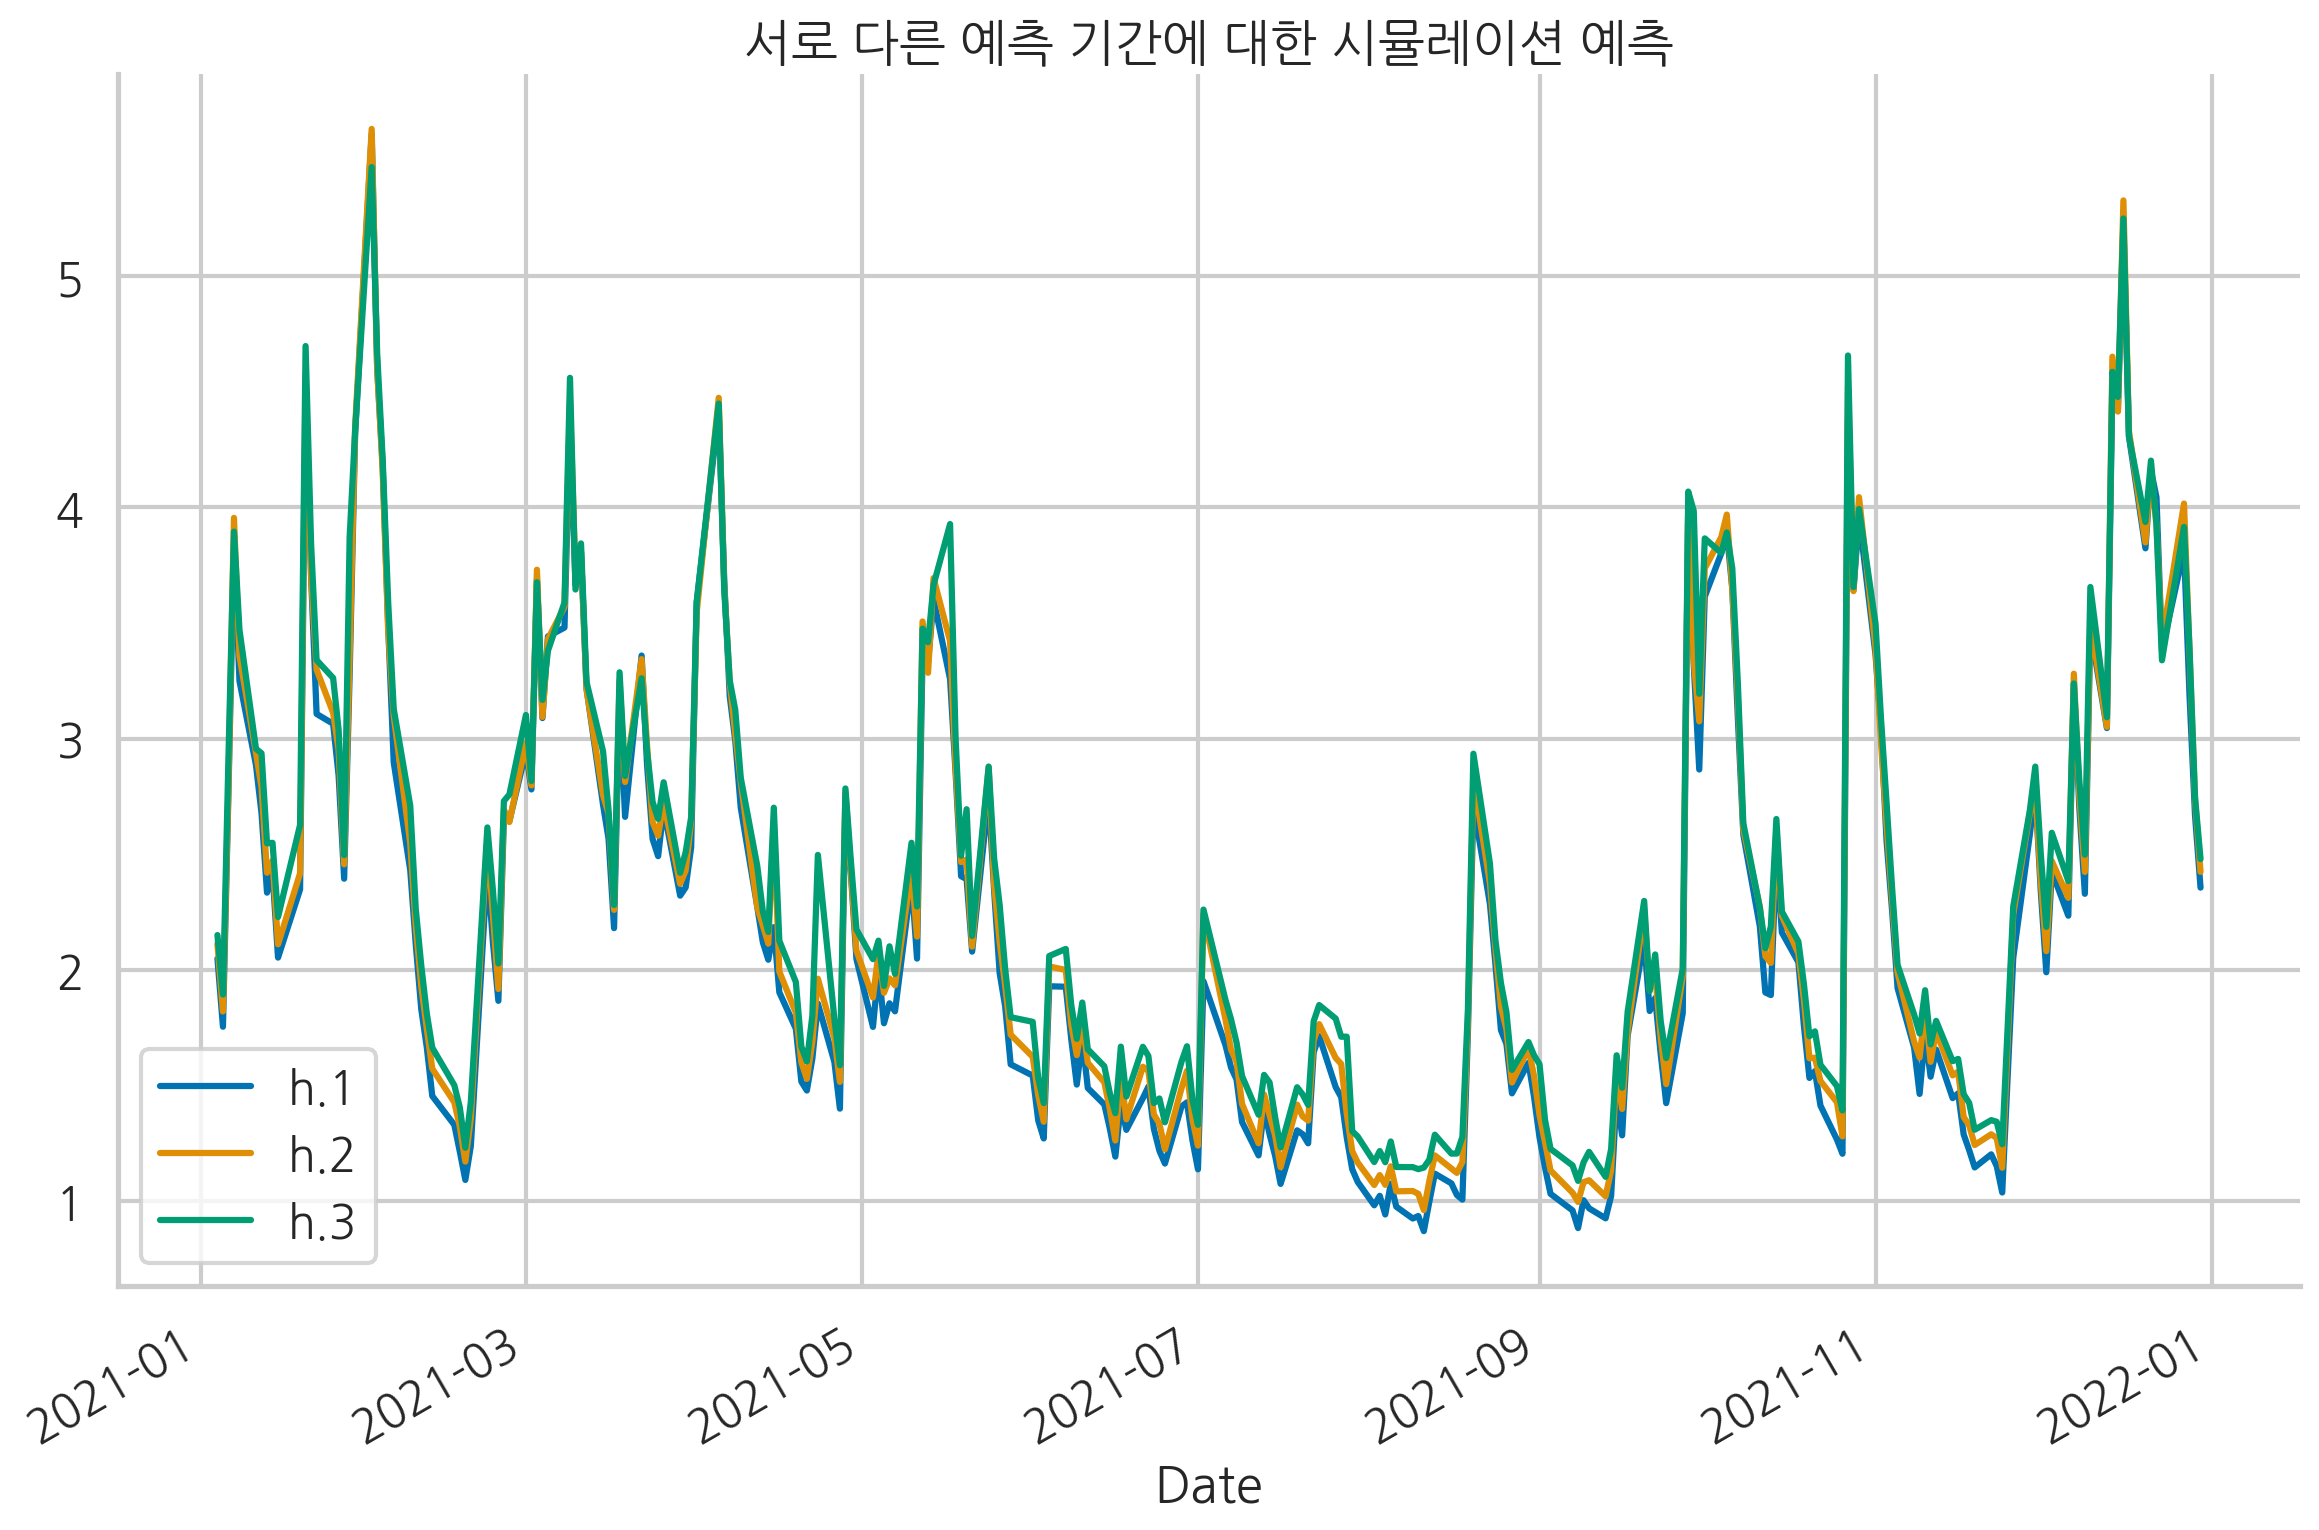

In [29]:
# 시뮬레이션 방법을 사용하여 GARCH 모델의 예측을 생성합니다
forecasts_simulation = fitted_model.forecast(horizon=3,  # 3일 앞을 예측
                                             start=SPLIT_DATE,  # 예측 시작일
                                             method="simulation",  # 시뮬레이션 방법 사용
                                             reindex=False)  # 원본 인덱스 유지

# 예측된 변동성을 시각화합니다
forecasts_simulation.variance.plot(
    title="서로 다른 예측 기간에 대한 시뮬레이션 예측"
)

# 그래프 스타일 조정
sns.despine()  # 상단과 우측 테두리 제거
plt.tight_layout()  # 그래프 레이아웃 최적화

# 그래프를 파일로 저장 (필요시 주석 해제)
# plt.savefig("images/figure_9_6", dpi=200)

In [30]:
forecasts_simulation.variance

,h.1,h.2,h.3
Date,,,
2021-01-04,2.048970,2.112709,2.150351
2021-01-05,1.754038,1.819990,1.893276
2021-01-06,2.770909,2.796981,2.918608
2021-01-07,3.838416,3.954136,3.894672
2021-01-08,3.248873,3.357723,3.469723
...,...,...,...
2021-12-23,3.380792,3.420389,3.338366
2021-12-27,3.817191,4.015999,3.915146
2021-12-28,3.185615,3.376075,3.389716


7. Create and inspect the bootstrap forecasts:

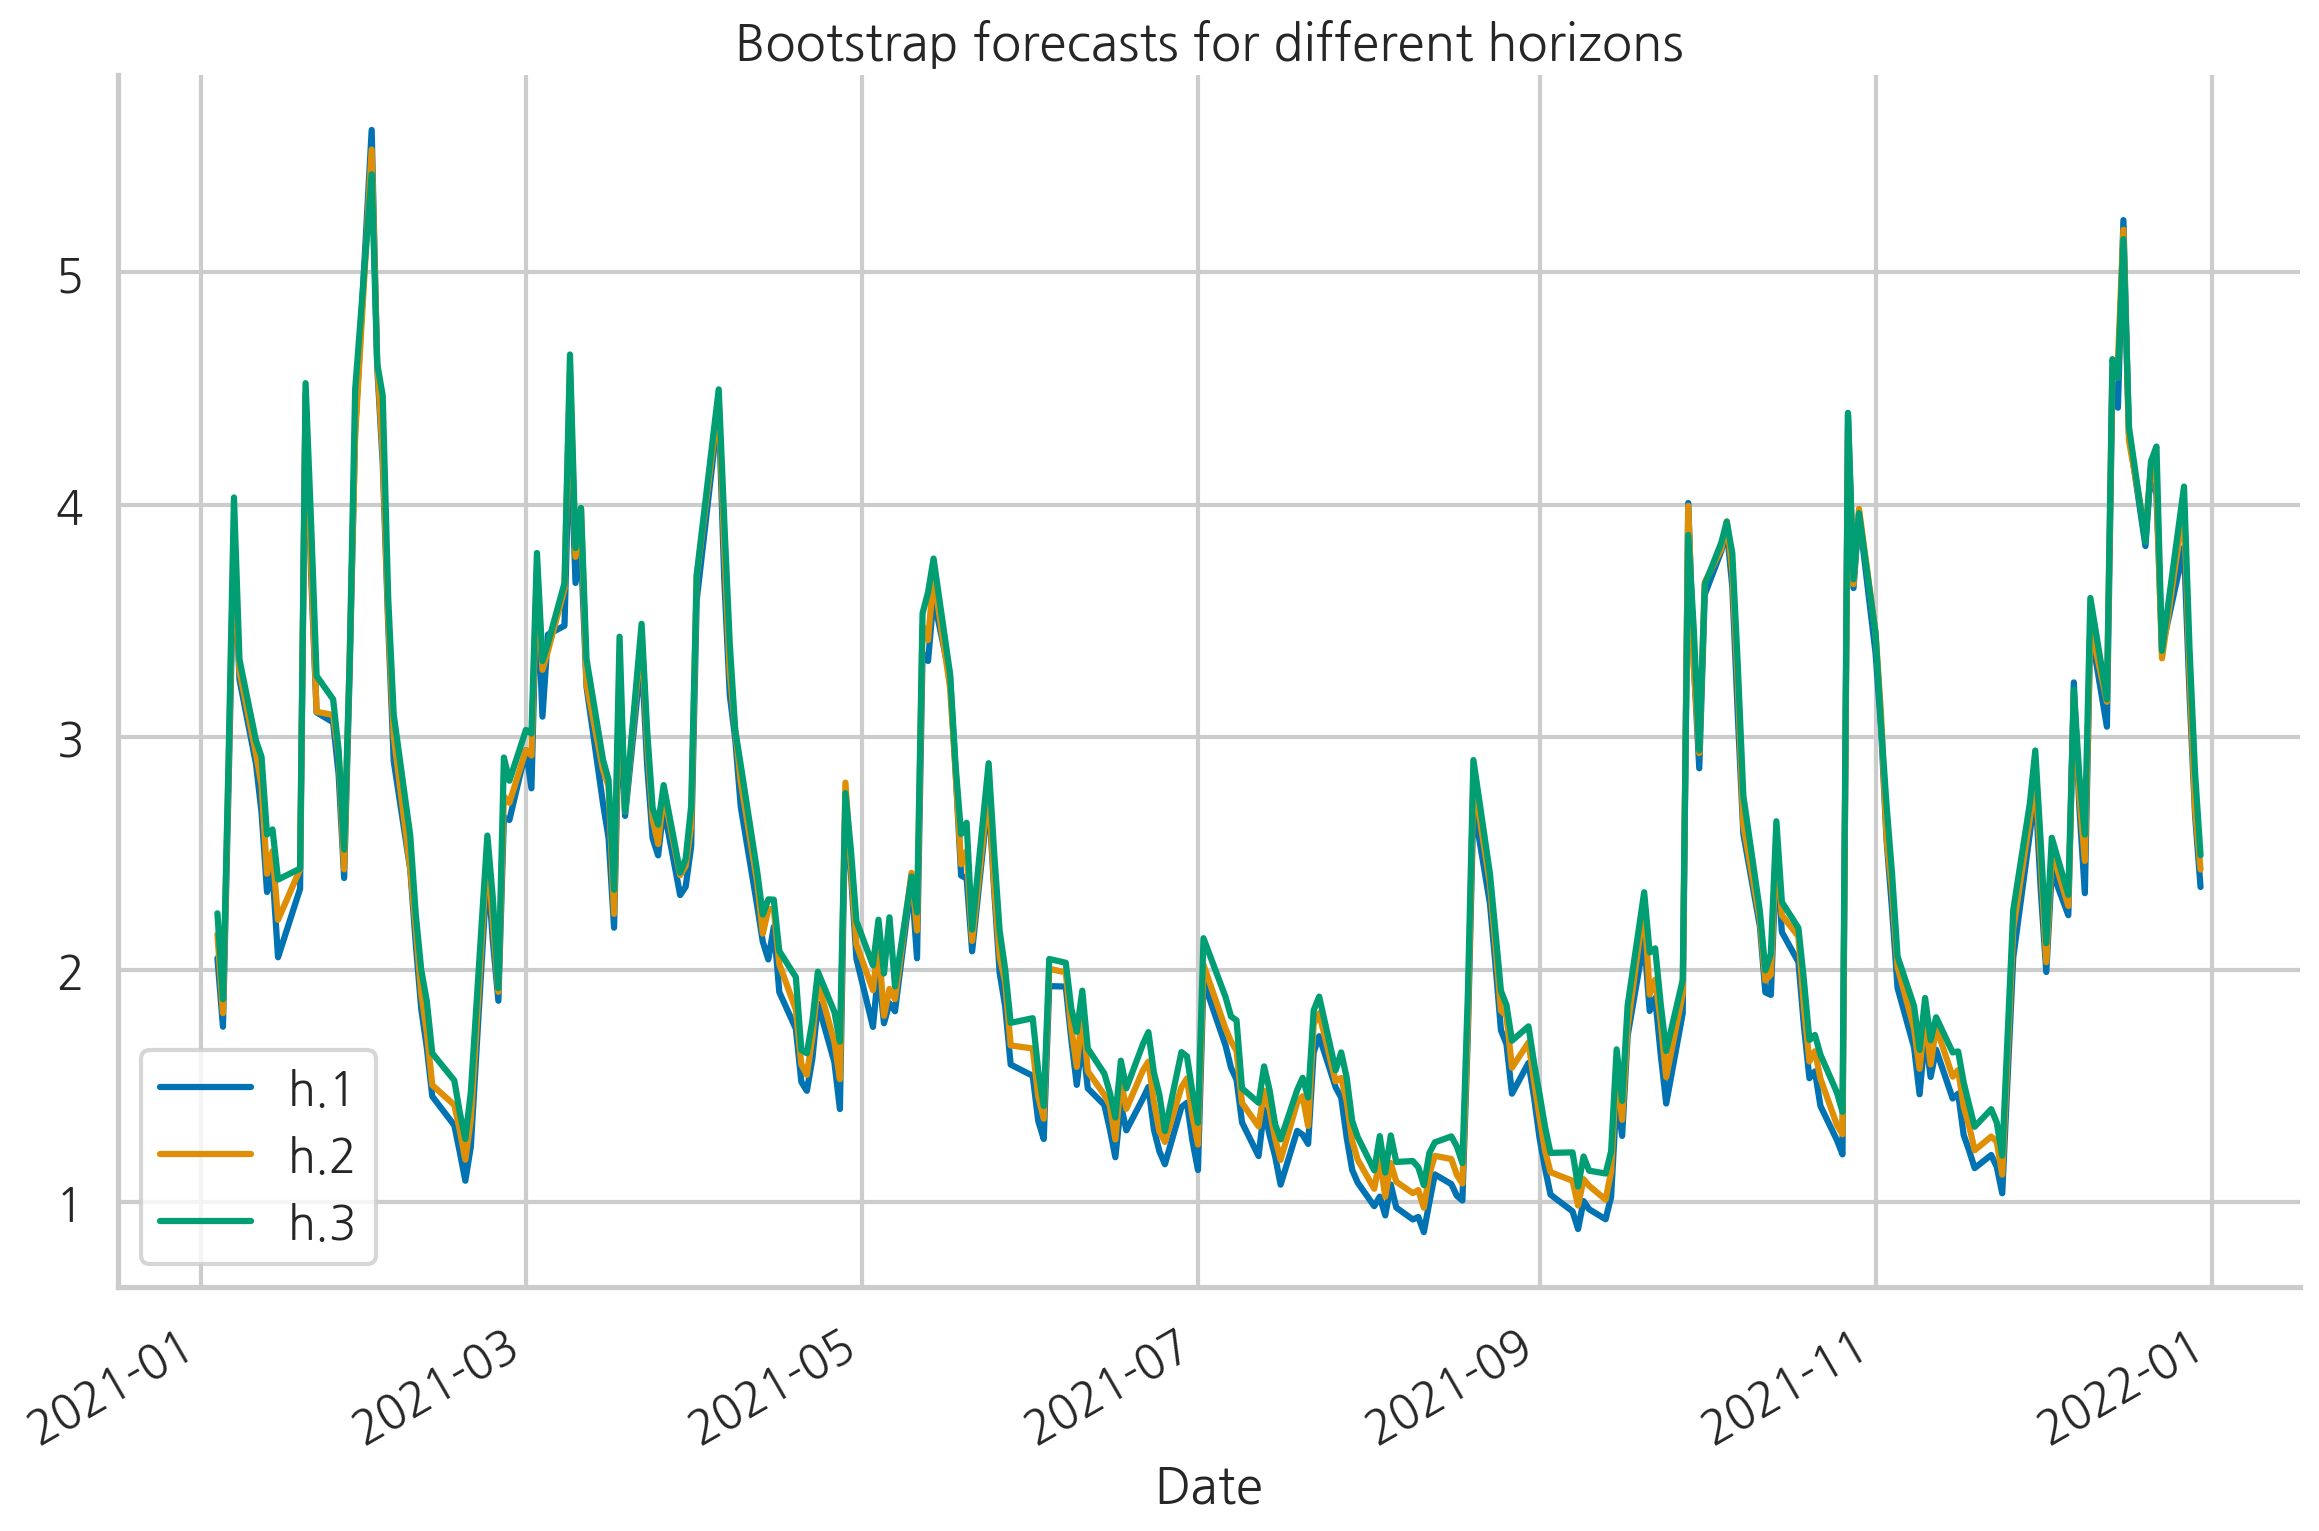

In [31]:
forecasts_bootstrap = fitted_model.forecast(horizon=3, 
                                            start=SPLIT_DATE,
                                            method="bootstrap",
                                            reindex=False)
forecasts_bootstrap.variance.plot(
    title="Bootstrap forecasts for different horizons"
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_7", dpi=200)

In [32]:
forecasts_bootstrap.variance

,h.1,h.2,h.3
Date,,,
2021-01-04,2.048970,2.151399,2.242145
2021-01-05,1.754038,1.812499,1.872347
2021-01-06,2.770909,2.850941,2.882775
2021-01-07,3.838416,3.879364,4.031610
2021-01-08,3.248873,3.285093,3.334287
...,...,...,...
2021-12-23,3.380792,3.339276,3.371643
2021-12-27,3.817191,3.999159,4.078481
2021-12-28,3.185615,3.276991,3.382102


### There's more

우리는 다양한 예측 접근 방식을 사용하여 얻은 예측 차이를 시각적으로 비교할 수 있습니다. 이 경우, 분석적 방법과 부트스트랩 방법을 2020년 동안 비교해 보고자 합니다. 2020년은 훈련 샘플에서 사용된 마지막 해였기 때문에 선택했습니다.

1. Import the libraries:

In [33]:
import numpy as np

2. Estimate the volatility forecasts for 2020 using the analytic and bootstrap approaches:

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 예측 기간 설정
FCST_HORIZON = 10

# 분석적 방법을 사용한 변동성 예측
vol_analytic = (
    fitted_model.forecast(horizon=FCST_HORIZON)
    .residual_variance
    .apply(np.sqrt)
)

# 부트스트랩 방법을 사용한 변동성 예측
vol_bootstrap = (
    fitted_model.forecast(horizon=FCST_HORIZON, 
                          method="bootstrap")
    .residual_variance
    .apply(np.sqrt)
)

In [35]:
# # 예측 기간 설정
# FCST_HORIZON = 10

# # 분석적 방법을 사용한 변동성 예측
# vol_analytic = (
#     fitted_model.forecast(horizon=FCST_HORIZON, 
#                           start=datetime(2020, 1, 1),
#                           reindex=False)
#     .residual_variance["2020"]  # 2020년 데이터만 선택
#     .apply(np.sqrt)  # 표준편차로 변환
# )

# # 부트스트랩 방법을 사용한 변동성 예측
# vol_bootstrap = (
#     fitted_model.forecast(horizon=FCST_HORIZON, 
#                           start=datetime(2020, 1, 1),
#                           method="bootstrap",  # 부트스트랩 방법 사용
#                           reindex=False)
#     .residual_variance["2020"]  # 2020년 데이터만 선택
#     .apply(np.sqrt)  # 표준편차로 변환
# )

# # 두 방법 모두 2020년 1월 1일부터 시작하여 10일 동안의 변동성을 예측합니다.
# # 결과는 표준편차 형태로 반환됩니다.


In [36]:
# print(fitted_model.conditional_volatility.index)


3. Get the conditional volatility for 2020:

In [37]:
# vol = fitted_model.conditional_volatility["2020"]

In [38]:
# 2020년 데이터 필터링
vol_analytic_2020 = vol_analytic.loc['2020']
vol_bootstrap_2020 = vol_bootstrap.loc['2020']

# 조건부 변동성 가져오기
vol = fitted_model.conditional_volatility.loc['2020']

4. Create the hedgehog plot:

In [39]:
# # 변동성 데이터를 플롯합니다.
# ax = vol.plot(
#     title="분석적 방법과 부트스트랩 방법의 변동성 예측 비교",
#     alpha=0.5  # 투명도를 설정하여 겹치는 부분을 더 잘 볼 수 있게 합니다.
# )
# ind = vol.index  # 인덱스를 저장합니다.

# # 10일 간격으로 예측을 플롯합니다.
# for i in range(0, 240, 10):
#     vol_a = vol_analytic.iloc[i]  # 분석적 방법의 예측값
#     vol_b = vol_bootstrap.iloc[i]  # 부트스트랩 방법의 예측값
#     start_loc = ind.get_loc(vol_a.name)  # 예측 시작 위치를 찾습니다.
#     new_ind = ind[(start_loc+1):(start_loc+FCST_HORIZON+1)]  # 새로운 인덱스를 생성합니다.
#     vol_a.index = new_ind  # 분석적 방법 예측값의 인덱스를 업데이트합니다.
#     vol_b.index = new_ind  # 부트스트랩 방법 예측값의 인덱스를 업데이트합니다.
#     ax.plot(vol_a, color="r")  # 분석적 방법 예측을 빨간색으로 플롯합니다.
#     ax.plot(vol_b, color="g")  # 부트스트랩 방법 예측을 초록색으로 플롯합니다.

# # 범례를 추가합니다.
# labels = ["실제 변동성", "분석적 방법 예측", "부트스트랩 방법 예측"]
# legend = ax.legend(labels)

# # 그래프를 깔끔하게 만듭니다.
# sns.despine()  # 상단과 우측의 축을 제거합니다.
# plt.tight_layout()  # 그래프 레이아웃을 조정합니다.

# # 그래프를 파일로 저장하려면 아래 줄의 주석을 제거하세요.
# # plt.savefig("images/figure_9_8", dpi=200)

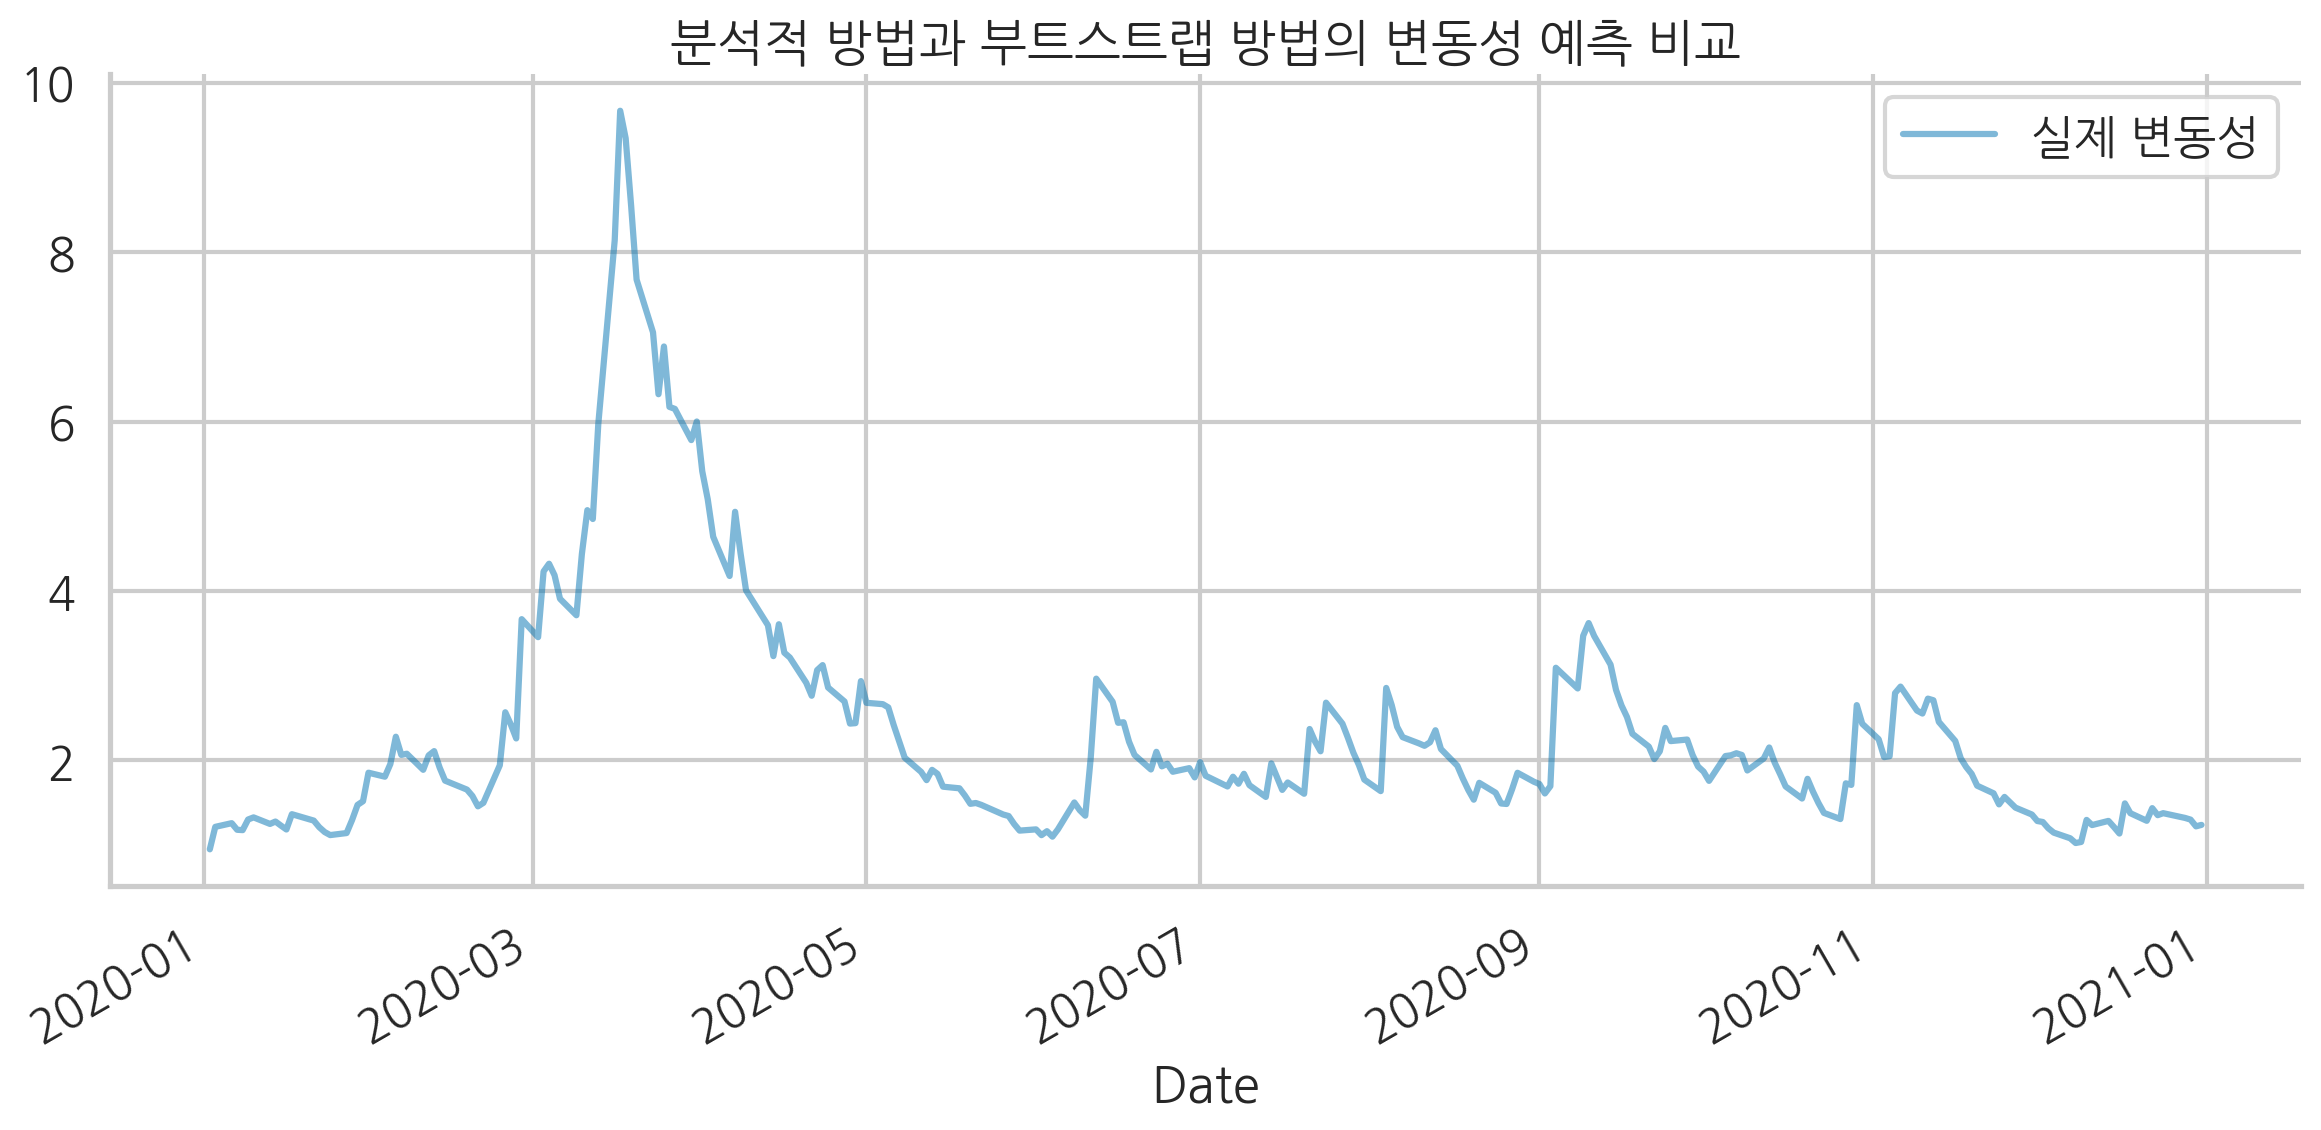

In [40]:
# 변동성 데이터를 플롯합니다.
fig, ax = plt.subplots(figsize=(12, 6))
vol.plot(ax=ax, title="분석적 방법과 부트스트랩 방법의 변동성 예측 비교", alpha=0.5)
ind = vol.index

# 10일 간격으로 예측을 플롯합니다.
for i in range(0, len(vol_analytic_2020), 10):
    vol_a = vol_analytic_2020.iloc[i]
    vol_b = vol_bootstrap_2020.iloc[i]
    start_loc = ind.get_loc(vol_a.name)
    new_ind = ind[(start_loc+1):(start_loc+FCST_HORIZON+1)]
    if len(new_ind) > 0:
        ax.plot(new_ind, vol_a, color="r", alpha=0.3)
        ax.plot(new_ind, vol_b, color="g", alpha=0.3)

# 범례를 추가합니다.
labels = ["실제 변동성", "분석적 방법 예측", "부트스트랩 방법 예측"]
ax.legend(labels)

# 그래프를 깔끔하게 만듭니다.
sns.despine()
plt.tight_layout()
plt.show()

**Hedgehog Plot에 대한 설명**

**Hedgehog plot**은 두 가지 예측 접근 방식을 장기간에 걸쳐 비교하는 데 유용한 시각화 방법입니다. 이 경우, 우리는 10단계 앞 예측을 10일 간격으로 시각화했습니다.

2020년 3월에 발생한 변동성의 급증이 흥미롭습니다. 변동성의 정점 근처에서 GARCH 모델은 향후 며칠 동안 변동성 감소를 예측하고 있음을 확인할 수 있습니다. 이 예측이 어떻게 만들어졌는지 더 잘 이해하려면 기초 데이터를 참조할 수 있습니다. 관찰된 변동성과 예측을 포함한 DataFrame을 확인하면, 변동성의 정점은 3월 17일에 발생했으며, 시각화된 예측은 3월 16일까지의 데이터를 사용해 생성된 것임을 알 수 있습니다.

> 하나의 변동성 모델을 개별적으로 분석할 때는, 적합된 **arch_model**의 `hedgehog_plot` 메서드를 사용하여 유사한 플롯을 만드는 것이 더 쉬울 수 있습니다.

## 9.4 Multivariate volatility forecasting with the CCC-GARCH model

**CCC-GARCH 모델을 이용한 다변량 변동성 예측**

이 장에서는 이미 여러 단변량 조건부 변동성 모델을 고려했습니다. 이번에는 다변량 설정으로 넘어가 Bollerslev의 **상수 조건부 상관관계 GARCH(CCC-GARCH)** 모델을 사용합니다. 이 모델의 아이디어는 매우 간단합니다. 이 모델은 상수 조건부 상관 행렬 $ R $을 통해 서로 연관된 N개의 단변량 GARCH 모델로 구성됩니다.

이전과 같이, 우리는 모델의 명세로 시작합니다:

$
r_t = \mu + \epsilon_t
$

$
\epsilon_t \sim N(0, \Sigma_t)
$

$
\Sigma_t = D_t R D_t
$

첫 번째 방정식에서는 수익률 시계열을 나타냅니다. 이번에는 다변량 수익률을 고려하기 때문에 이전에 제시한 표현과의 주요 차이점이 있습니다. 즉, $ r_t $는 실제로 수익률의 벡터 $ r_t = (r_{1t}, ..., r_{nt}) $입니다. 평균과 오차 항은 유사하게 표현됩니다. 벡터 또는 행렬을 고려할 때, 이를 강조하기 위해 굵은 글꼴을 사용합니다.

두 번째 방정식에서는 오차 항이 평균이 0인 다변량 정규분포에서 오며, 조건부 공분산 행렬 $ \Sigma_t $를 따르는 것을 보여줍니다. $ \Sigma_t $의 크기는 $ N \times N $입니다.

조건부 공분산 행렬의 요소는 다음과 같이 정의됩니다:

- 대각선:
$
\sigma_{ii,t}^2 = \omega_{it} + \sum_{q=1}^{Q} \alpha_{iiq} \epsilon_{i,t-q}^2 + \sum_{p=1}^{P} \beta_{iip} \sigma_{ii,t-p}^2 \quad \text{for } i = 1, ..., N
$
- 비대각선:
$
\sigma_{ij,t}^2 = \rho_{ij} \sigma_{ii,t} \sigma_{jj,t} \quad \text{for } i \neq j
$

세 번째 방정식은 조건부 공분산 행렬의 분해를 나타냅니다. $ D_t $는 대각선에 조건부 표준 편차를 포함하는 행렬을 나타내며, $ R $은 상관 행렬입니다.

이 모델의 핵심 아이디어는 다음과 같습니다:
- 이 모델은 분산과 상관관계로 분리하여 $ \Sigma_t $의 양의 정부호성 보장 문제를 피합니다.
- 오차 항 간의 조건부 상관관계는 시간에 따라 일정하게 유지됩니다.
- 개별 조건부 분산은 단변량 GARCH(1,1) 모델을 따릅니다.


이 예제에서는 세 개의 미국 기술 기업 주식 수익률 시계열에 대해 CCC-GARCH 모델을 추정합니다. CCC-GARCH 모델의 추정에 대한 자세한 내용은 '작동 방식...' 섹션을 참고하세요.

### How to do it...

1. Import the libraries:

In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
from arch import arch_model

2. Specify the risky asset and the time horizon:

In [10]:
RISKY_ASSETS = ["GOOG", "MSFT", "AAPL"]
START_DATE = "2015-01-01"
END_DATE = "2021-12-31"

3. Download data from Yahoo Finance:

In [11]:
df = yf.download(RISKY_ASSETS,
                 start=START_DATE,
                 end=END_DATE)

print(f"다운로드된 데이터 행 수: {df.shape[0]}")

[*********************100%***********************]  3 of 3 completed

다운로드된 데이터 행 수: 1762


4. Calculate daily returns:

**Step 2**와 **Step 3**에서 우리는 Google, Microsoft, Apple의 일일 주가 데이터를 다운로드한 후, 간단한 수익률을 계산하고 수렴 오류를 피하기 위해 100을 곱합니다.


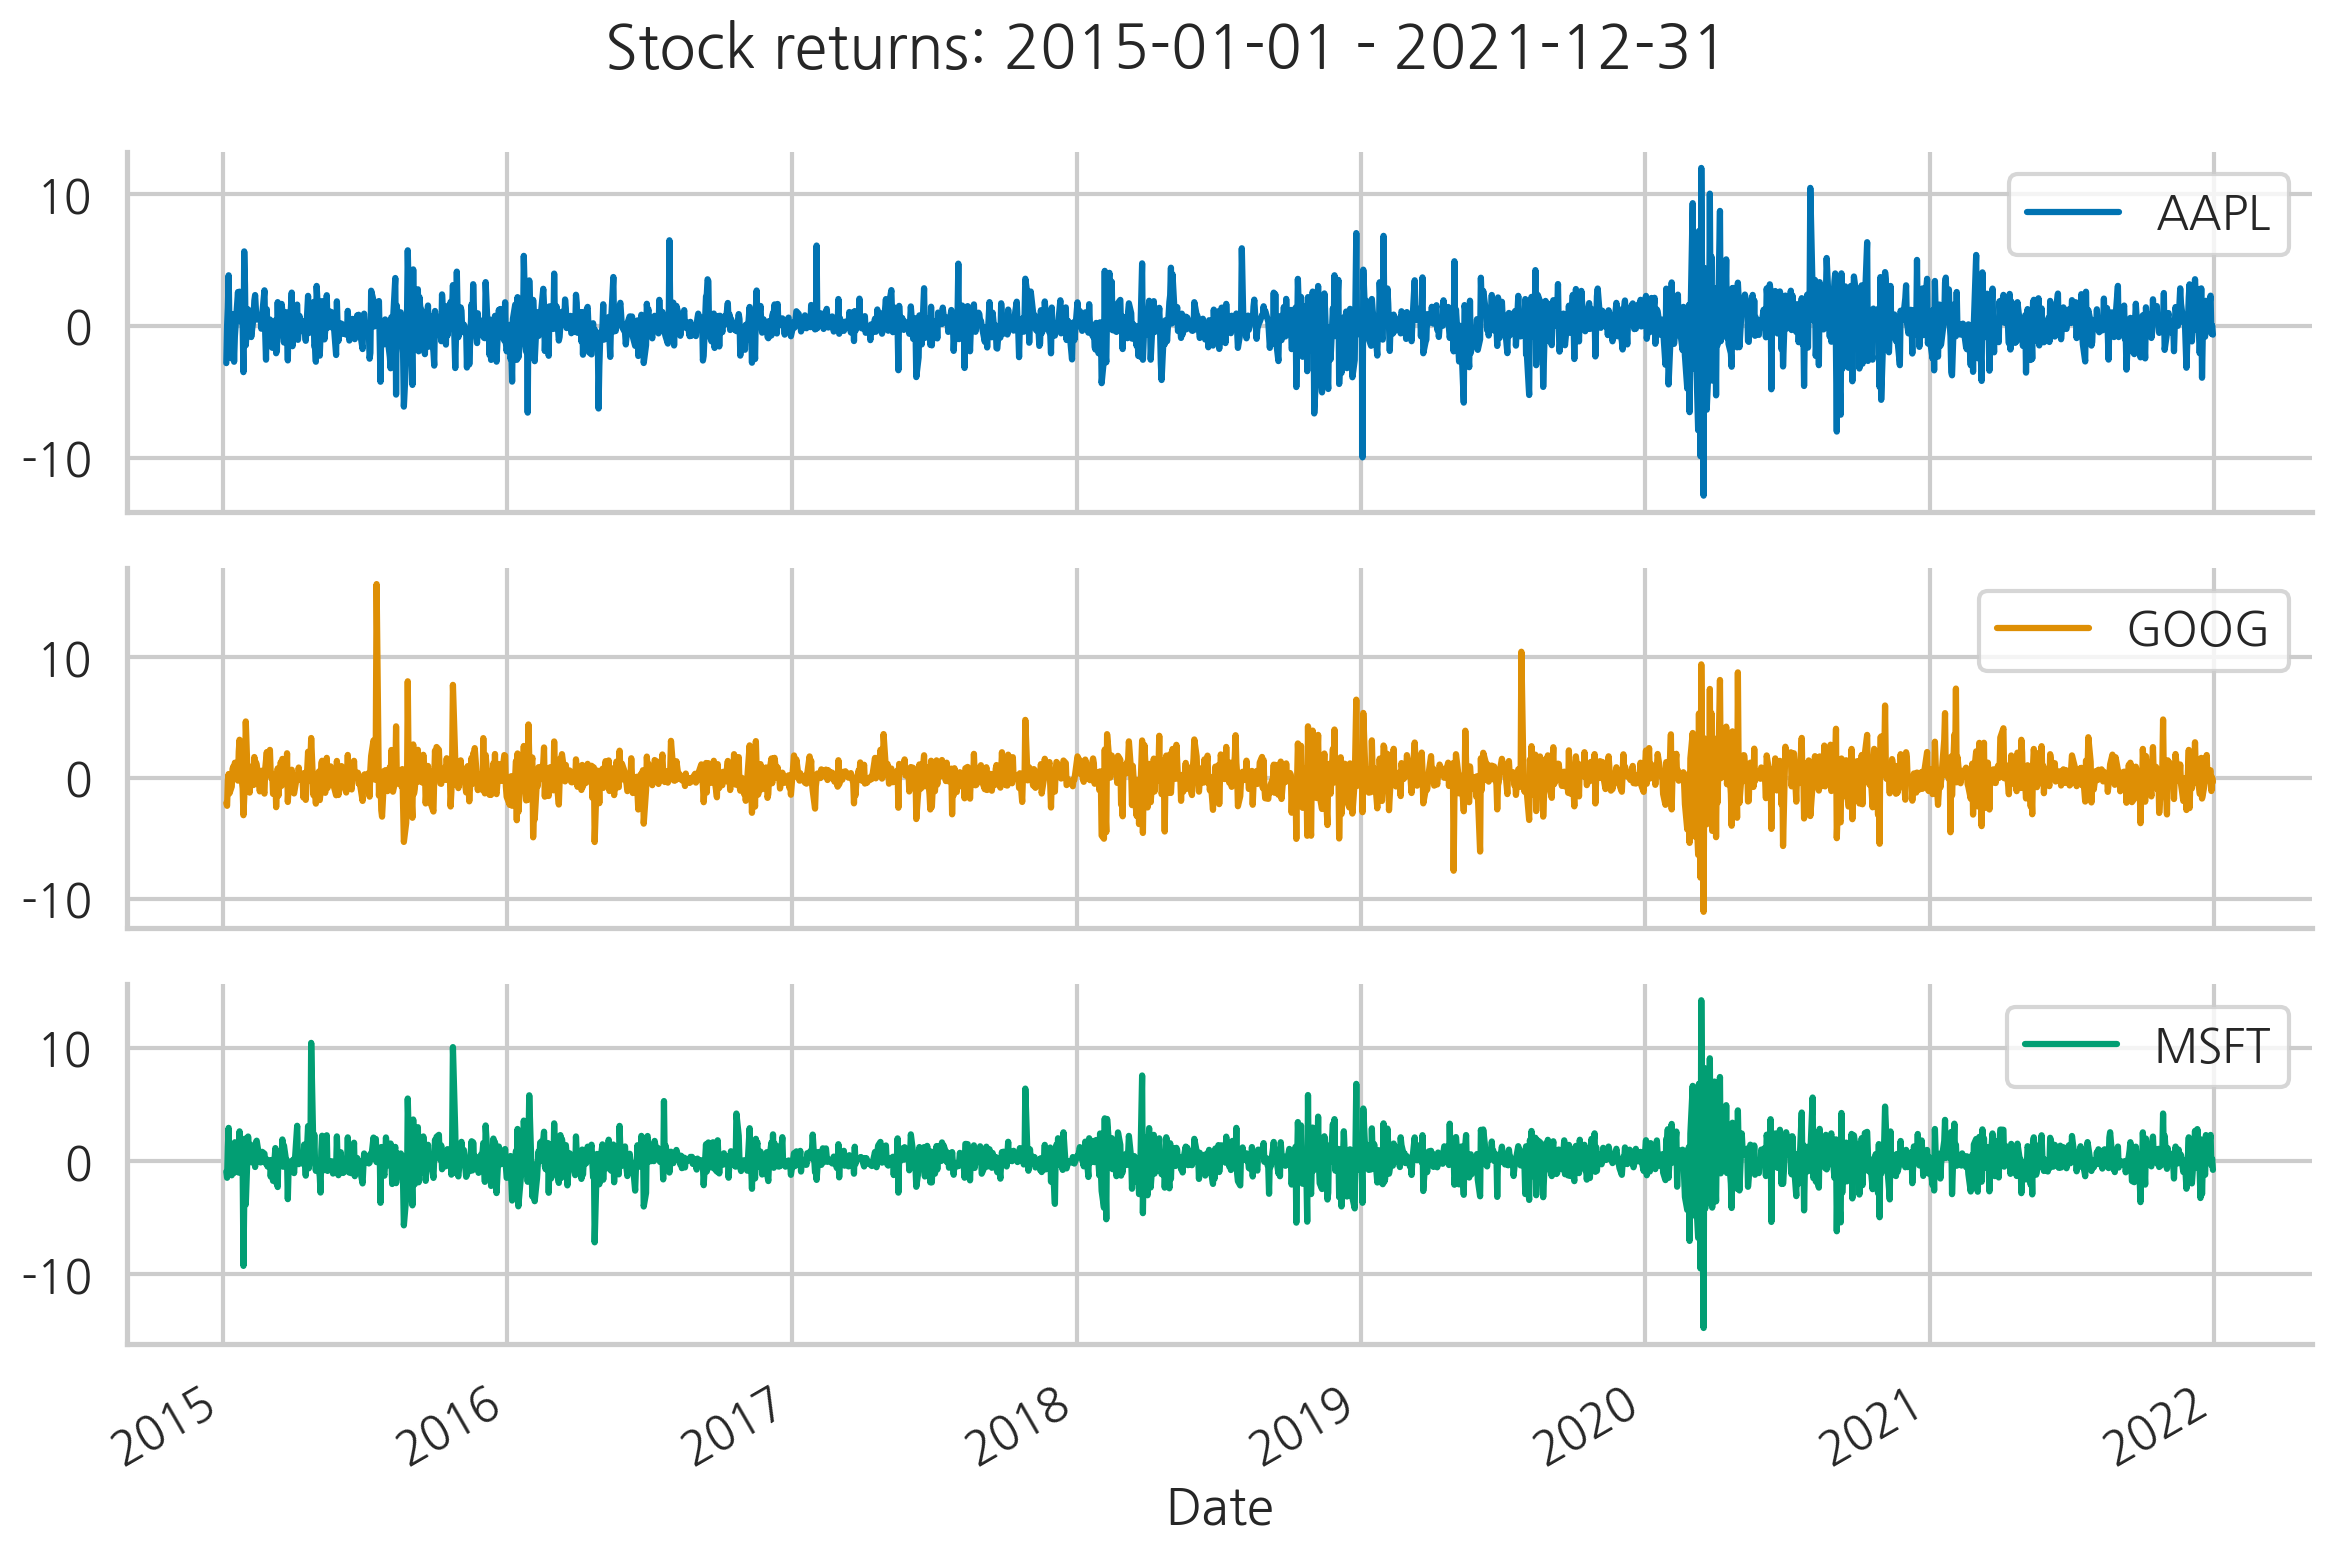

In [12]:
# 주가의 일일 수익률을 계산하고 100을 곱하여 백분율로 변환합니다.
returns = 100 * df["Adj Close"].pct_change().dropna()

# 각 주식의 수익률을 개별 서브플롯으로 그립니다.
returns.plot(subplots=True, 
             title=f"Stock returns: {START_DATE} - {END_DATE}")

# 그래프의 테두리를 제거하여 깔끔하게 만듭니다.
sns.despine()

# 그래프의 레이아웃을 자동으로 조정하여 보기 좋게 만듭니다.
plt.tight_layout()

# 그래프를 이미지 파일로 저장하는 코드 (현재는 주석 처리됨)
# plt.savefig("images/figure_9_9", dpi=200)

5. Define lists for storing objects:

**Step 5**에서는 이후 단계에서 필요한 요소들을 저장할 빈 리스트를 정의합니다. 여기에는 GARCH 계수, 조건부 변동성, 표준화된 잔차, 예측에 사용되는 모델 자체가 포함됩니다.

In [15]:
# GARCH 모델의 계수를 저장할 리스트
coeffs = []

# 조건부 변동성을 저장할 리스트
cond_vol = []

# 표준화된 잔차를 저장할 리스트
std_resids = []

# GARCH 모델 객체를 저장할 리스트
models = []

6. Estimate the univariate GARCH models:

**Step 6**에서는 주식 수익률을 포함하는 DataFrame의 열을 반복 처리하여 각 시계열에 대해 단변량 GARCH 모델을 적용합니다. 결과는 미리 정의된 리스트에 저장합니다. 그런 다음 잔차와 같은 객체를 DataFrame에 포함하여 데이터 처리와 작업을 쉽게 할 수 있도록 데이터를 정리합니다.

In [16]:
for asset in returns.columns:
    # 각 자산에 대해 GARCH 모델을 지정하고 적합시킵니다.
    model = arch_model(returns[asset], mean="Constant", 
                       vol="GARCH", p=1, q=1)
    model = model.fit(update_freq=0, disp="off");
    
    # 결과를 리스트에 저장합니다.
    coeffs.append(model.params)  # GARCH 모델의 계수를 저장합니다.
    cond_vol.append(model.conditional_volatility)  # 조건부 변동성을 저장합니다.
    std_resids.append(model.std_resid)  # 표준화된 잔차를 저장합니다.
    models.append(model)  # GARCH 모델 객체를 저장합니다.

7. Store the results in DataFrames:

In [17]:
# GARCH 모델의 계수를 DataFrame으로 변환합니다.
coeffs_df = pd.DataFrame(coeffs, index=returns.columns)

# 조건부 변동성을 DataFrame으로 변환하고, 열 이름을 주식 수익률의 열 이름과 동일하게 설정합니다.
cond_vol_df = (
    pd.DataFrame(cond_vol)  # 리스트를 DataFrame으로 변환합니다.
    .transpose()  # DataFrame을 전치(transpose)합니다.
    .set_axis(returns.columns,  # 열 이름을 주식 수익률의 열 이름과 동일하게 설정합니다.
              axis="columns")
)

# 표준화된 잔차를 DataFrame으로 변환하고, 열 이름을 주식 수익률의 열 이름과 동일하게 설정합니다.
std_resids_df = (
    pd.DataFrame(std_resids)  # 리스트를 DataFrame으로 변환합니다.
    .transpose()  # DataFrame을 전치(transpose)합니다.
    .set_axis(returns.columns,  # 열 이름을 주식 수익률의 열 이름과 동일하게 설정합니다.
              axis="columns")
)

In [18]:
coeffs_df

,mu,omega,alpha[1],beta[1]
Ticker,,,,
AAPL,0.189583,0.176260,0.134657,0.811612
GOOG,0.125469,0.305894,0.183854,0.715030
MSFT,0.149252,0.267587,0.213113,0.700489


8. Calculate the constant conditional correlation matrix (R):

**Step 8**에서는 다음과 같이 상수 조건부 상관 행렬( $ R $ )을 계산합니다:

$
R = \frac{1}{T} \sum_{t=1}^{T} z_t z_t'
$

여기서 $ z_t $는 단변량 GARCH 모델에서 얻은 시점 $ t $의 표준화된 잔차를 의미합니다.


In [19]:
# 표준화된 잔차의 전치 행렬과 원래 표준화된 잔차 행렬을 곱하여 상수 조건부 상관 행렬 R을 계산합니다.
# 이때, 각 요소를 표준화된 잔차 행렬의 행 수로 나누어 평균을 구합니다.
R = (
    std_resids_df
    .transpose()  # 표준화된 잔차 행렬을 전치합니다.
    .dot(std_resids_df)  # 전치된 행렬과 원래 행렬을 곱합니다.
    .div(len(std_resids_df))  # 행 수로 나누어 평균을 구합니다.
)

9. Calculate the 1-step ahead forecast of the conditional covariance matrix :

마지막 단계에서, 우리는 조건부 공분산 행렬 $ H_{t+1} $의 한 스텝 앞 예측값을 얻습니다. 이를 위해 다음과 같은 작업을 수행합니다:

- **$ D_{t+1} $** 행렬을 0으로 초기화하고, `np.zeros`를 사용합니다.
- 단변량 GARCH 모델에서 조건부 분산의 한 스텝 앞 예측값을 리스트 `diag`에 저장합니다.
- `np.fill_diagonal`을 사용하여, `diag` 리스트의 요소를 $ D_{t+1} $ 행렬의 대각선에 배치합니다.
- 도입부의 방정식 3을 따라, 행렬 곱셈 `np.matmul`을 사용하여 한 스텝 앞 예측값을 얻습니다.

In [20]:
# 객체를 정의합니다
diag = []  # 조건부 분산을 저장할 리스트를 초기화합니다.
D = np.zeros((len(RISKY_ASSETS), len(RISKY_ASSETS)))  # 대각 행렬 D를 0으로 초기화합니다.

# 조건부 분산으로 리스트를 채웁니다
for model in models:
    diag.append(model.forecast(horizon=1).variance.iloc[-1, 0])  # 각 모델의 조건부 분산을 예측하여 리스트에 추가합니다.
# 분산에서 변동성을 얻기 위해 제곱근을 구합니다
diag = np.sqrt(diag)  # 리스트의 각 요소에 대해 제곱근을 구하여 변동성을 계산합니다.
# diag의 값을 사용하여 D의 대각선을 채웁니다
np.fill_diagonal(D, diag)  # 대각 행렬 D의 대각선에 변동성 값을 채웁니다.

# 조건부 공분산 행렬을 계산합니다
H = np.matmul(np.matmul(D, R.values), D)  # 행렬 곱셈을 사용하여 조건부 공분산 행렬 H를 계산합니다.

In [21]:
H

array([[2.39811361, 1.0056534 , 1.19870235],
       [1.0056534 , 1.51517906, 1.12098123],
       [1.19870235, 1.12098123, 1.87602372]])

## See also 

Additional resources are available here: 
- Bollerslev, T.1990. “Modeling the Coherence in Short-Run Nominal Exchange Rates: A Multivariate Generalized ARCH Approach,” Review of Economics and Statistics, 72(3): 498–505: https://doi.org/10.2307/2109358

## 9.5 Forecasting the conditional covariance matrix using DCC-GARCH

**DCC-GARCH를 사용한 조건부 공분산 행렬 예측**

이 방법에서는 CCC-GARCH 모델의 확장인 Engle의 **동적 조건부 상관관계 GARCH**(DCC-GARCH) 모델을 다룹니다. 두 모델의 주요 차이점은 DCC-GARCH 모델에서는 조건부 상관관계 행렬이 시간에 따라 일정하지 않다는 것입니다. 우리는 $ R_t $와 함께 작업하며, $ R $ 대신 사용합니다.

추정 방법에는 몇 가지 미묘한 차이가 있지만, 전체적인 개요는 CCC-GARCH 모델과 유사합니다.

- 조건부 변동성을 위한 단일 변량 GARCH 모델을 추정합니다.
- 조건부 상관관계를 위한 DCC 모델을 추정합니다.

DCC 모델의 두 번째 단계에서는 대리 상관관계 과정을 나타내는 새로운 행렬 $ Q_t $를 사용합니다.

$
R_t = \text{diag}(Q_t)^{-1/2} Q_t \text{diag}(Q_t)^{-1/2}
$

$
Q_t = (1 - \gamma - \delta) \overline{Q} + \gamma z_{t-1} z'_{t-1} + \delta Q_{t-1}
$

$
\overline{Q} = \frac{1}{T} \sum_{t=1}^{T} z_t z'_t
$

첫 번째 방정식은 조건부 상관관계 행렬 $ R_t $와 대리 과정 $ Q_t $ 간의 관계를 설명합니다. 두 번째 방정식은 대리 과정의 동역학을 나타냅니다. 마지막 방정식은 $ \overline{Q} $의 정의를 보여줍니다. 이 값은 단일 변량 GARCH 모델의 표준화된 잔차의 무조건부 상관관계 행렬로 정의됩니다.

이 DCC 모델의 표현은 **상관관계 타겟팅**이라는 접근 방식을 사용합니다. 이것은 우리가 추정해야 할 매개변수의 수를 두 개로 줄인다는 의미입니다: $ \gamma $와 $ \delta $. 이는 단일 변량 GARCH 모델에서 변동성 타겟팅과 유사합니다. 이는 추가 설명이 필요한 섹션에 더 자세히 설명됩니다.

현재 DCC-GARCH 모델을 추정할 수 있는 Python 라이브러리는 없습니다. 한 가지 해결책은 처음부터 이러한 라이브러리를 작성하는 것입니다. 또 다른 더 효율적인 해결책은 해당 작업을 위한 잘 확립된 R 패키지를 사용하는 것입니다. 그래서 이 방법에서는 Python과 R을 한 Jupyter 노트북에서 함께 사용할 수 있는 방법을 소개합니다. 이를 통해 우리는 R과 Python을 모두 하나의 노트북에서 실행할 수 있을 뿐만 아니라 두 언어 간 객체를 전송할 수도 있습니다.

이 방법에서는 이전 방법과 동일한 데이터를 사용하여 접근 방식과 결과의 차이점을 강조합니다.

### Getting ready

Before executing the following code, please make sure to run the code from the previous recipe to have the data available. 

R을 쉽게 설치하는 방법에 대한 자세한 내용은 다음 리소스를 참조하십시오.

- [https://cran.r-project.org/](https://cran.r-project.org/)
- [https://docs.anaconda.com/anaconda/user-guide/tasks/using-r-language/](https://docs.anaconda.com/anaconda/user-guide/tasks/using-r-language/)

만약 **conda**를 패키지 매니저로 사용한다면, 설정 과정이 매우 간단해질 수 있습니다. `conda install rpy2` 명령을 사용하여 **rpy2**를 설치하면 패키지 매니저가 최신 버전의 R과 다른 필요한 종속성을 자동으로 설치해 줍니다.

다음 코드를 실행하기 전에, 이전 예제의 코드를 먼저 실행하여 데이터를 준비하십시오.

### How to do it...

1. Import the libraries:

In [1]:
import pandas as pd

Setup the connection between Python and R using `rpy2`:

In [2]:
%load_ext rpy2.ipython

2. Install `rmgarch` R package and load it:

In [10]:
%reload_ext rpy2.ipython

In [11]:
%%R
install.packages(c("MASS", "Matrix", "nlme", "mgcv", "rugarch", "xts", "zoo", "parallel", "rmgarch"), repos = "http://cran.us.r-project.org")

R[write to console]: Warning:
R[write to console]:  dependencies ‘Matrix’, ‘MASS’ are not available

R[write to console]: also installing the dependencies ‘gmp’, ‘GeneralizedHyperbolic’, ‘Rmpfr’, ‘ks’, ‘SkewHyperbolic’, ‘Bessel’


R[write to console]: trying URL 'http://cran.us.r-project.org/src/contrib/gmp_0.7-5.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 166664 bytes (162 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to consol

checking for gcc... x86_64-conda-linux-gnu-cc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether x86_64-conda-linux-gnu-cc accepts -g... yes
checking for x86_64-conda-linux-gnu-cc option to accept ISO C89... none needed
checking how to run the C preprocessor... x86_64-conda-linux-gnu-cc -E
checking whether we are using the GNU C++ compiler... yes
checking whether x86_64-conda-linux-gnu-c++ -std=gnu++17 accepts -g... yes
checking for grep that handles long lines and -e... /usr/bin/grep
checking for egrep... /usr/bin/grep -E
checking for ANSI C header files... yes
checking for sys/types.h... yes
checking for sys/stat.h... yes
checking for stdlib.h... yes
checking for string.h... yes
checking for memory.h... yes
checking for strings.h... yes


configure: error: Header file gmp.h not found; maybe use --with-gmp-include=INCLUDE_PATH
ERROR: configuration failed for package ‘gmp’
* removing ‘/home/restful3/anaconda3/envs/ml4t/lib/R/library/gmp’
ERROR: dependency ‘MASS’ is not available for package ‘GeneralizedHyperbolic’
* removing ‘/home/restful3/anaconda3/envs/ml4t/lib/R/library/GeneralizedHyperbolic’
* installing *source* package ‘nlme’ ...
** package ‘nlme’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (Anaconda gcc) 11.2.0’
using Fortran compiler: ‘GNU Fortran (Anaconda gcc) 11.2.0’


x86_64-conda-linux-gnu-gfortran  -fpic  -fopenmp -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/restful3/anaconda3/envs/ml4t/include -fdebug-prefix-map=/workspace/croot/r-base_1695428141831/work=/usr/local/src/conda/r-base-4.3.1 -fdebug-prefix-map=/home/restful3/anaconda3/envs/ml4t=/usr/local/src/conda-prefix  -c chol.f -o chol.o
x86_64-conda-linux-gnu-cc -I"/home/restful3/anaconda3/envs/ml4t/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/restful3/anaconda3/envs/ml4t/include -I/home/restful3/anaconda3/envs/ml4t/include -Wl,-rpath-link,/home/restful3/anaconda3/envs/ml4t/lib   -fvisibility=hidden -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/restful3/anaconda3/envs/ml4t/include -fdebug-prefix-map=/workspace/croot/r-base_1695428141831/work=/usr/local/src/conda/r-base-4.3.1 -fdebug-prefix-m

installing to /home/restful3/anaconda3/envs/ml4t/lib/R/library/00LOCK-nlme/00new/nlme/libs
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (nlme)
* installing *source* package ‘zoo’ ...
** package ‘zoo’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (Anaconda gcc) 11.2.0’


x86_64-conda-linux-gnu-cc -I"/home/restful3/anaconda3/envs/ml4t/lib/R/include" -DNDEBUG -I../inst/include  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/restful3/anaconda3/envs/ml4t/include -I/home/restful3/anaconda3/envs/ml4t/include -Wl,-rpath-link,/home/restful3/anaconda3/envs/ml4t/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/restful3/anaconda3/envs/ml4t/include -fdebug-prefix-map=/workspace/croot/r-base_1695428141831/work=/usr/local/src/conda/r-base-4.3.1 -fdebug-prefix-map=/home/restful3/anaconda3/envs/ml4t=/usr/local/src/conda-prefix  -c coredata.c -o coredata.o
x86_64-conda-linux-gnu-cc -I"/home/restful3/anaconda3/envs/ml4t/lib/R/include" -DNDEBUG -I../inst/include  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/restful3/anaconda3/envs/ml4t/include -I/home/restful3/anaconda3/envs/ml4t/include -Wl,-rpath-link,/home/restful3/anaconda3/envs/ml4t/lib    -fpic  -march=nocona -mtune=

installing to /home/restful3/anaconda3/envs/ml4t/lib/R/library/00LOCK-zoo/00new/zoo/libs
** R
** demo
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (zoo)
ERROR: dependency ‘gmp’ is not available for package ‘Rmpfr’
* removing ‘/home/restful3/anaconda3/envs/ml4t/lib/R/library/Rmpfr’
ERROR: dependency ‘GeneralizedHyperbolic’ is not available for package ‘SkewHyperbolic’
* removing ‘/home/restful3/anaconda3/envs/ml4t/lib/R/library/SkewHyperbolic’
ERROR: dependency ‘Matrix’ is not available for package ‘mgcv’
* removing ‘/home/restful3/anaconda3/envs/ml4t/lib/R/library/mgcv’
* installing *source* package ‘

x86_64-conda-linux-gnu-cc -I"/home/restful3/anaconda3/envs/ml4t/lib/R/include" -DNDEBUG -I../inst/include -I'/home/restful3/anaconda3/envs/ml4t/lib/R/library/zoo/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/restful3/anaconda3/envs/ml4t/include -I/home/restful3/anaconda3/envs/ml4t/include -Wl,-rpath-link,/home/restful3/anaconda3/envs/ml4t/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/restful3/anaconda3/envs/ml4t/include -fdebug-prefix-map=/workspace/croot/r-base_1695428141831/work=/usr/local/src/conda/r-base-4.3.1 -fdebug-prefix-map=/home/restful3/anaconda3/envs/ml4t=/usr/local/src/conda-prefix  -c add_class.c -o add_class.o
x86_64-conda-linux-gnu-cc -I"/home/restful3/anaconda3/envs/ml4t/lib/R/include" -DNDEBUG -I../inst/include -I'/home/restful3/anaconda3/envs/ml4t/lib/R/library/zoo/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/restful3/anaconda3/envs/ml4t/include -

installing to /home/restful3/anaconda3/envs/ml4t/lib/R/library/00LOCK-xts/00new/xts/libs
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (xts)
ERROR: dependencies ‘Matrix’, ‘mgcv’ are not available for package ‘ks’
* removing ‘/home/restful3/anaconda3/envs/ml4t/lib/R/library/ks’
ERROR: dependency ‘Rmpfr’ is not available for package ‘Bessel’
* removing ‘/home/restful3/anaconda3/envs/ml4t/lib/R/library/Bessel’
ERROR: dependencies ‘ks’, ‘SkewHyperbolic’ are not available for package ‘rugarch’
* removing ‘/home/restful3/anaconda3/envs/ml4t/lib/R/library/rugarch’
ERROR: dependencies ‘rugarch’, ‘

In [12]:
%%R
library(rmgarch)

R[write to console]: Error in library(rmgarch) : there is no package called ‘rmgarch’

R[write to console]: In addition: 
R[write to console]: There were 11 warnings (use warnings() to see them)
R[write to console]: 




Error in library(rmgarch) : there is no package called ‘rmgarch’


RInterpreterError: Failed to parse and evaluate line 'library(rmgarch)\n'.
R error message: 'Error in library(rmgarch) : there is no package called ‘rmgarch’'

In [13]:
%%R
warnings()

Warning messages:
1: package ‘parallel’ is a base package, and should not be updated
2: packages ‘MASS’, ‘Matrix’ are not available for this version of R
‘MASS’ version 7.3-61 is in the repositories but depends on R (>= 4.4.0)
‘Matrix’ version 1.7-0 is in the repositories but depends on R (>= 4.4.0)
‘MASS’ version 7.3-61 is in the repositories but depends on R (>= 4.5)
‘Matrix’ version 1.7-0 is in the repositories but depends on R (>= 4.5)

Versions of these packages for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages
3: In install.packages(c("MASS", "Matrix", "nlme", "mgcv",  ... :
  installation of package ‘gmp’ had non-zero exit status
4: In install.packages(c("MASS", "Matrix", "nlme", "mgcv",  ... :
  installation of package ‘GeneralizedHyperbolic’ had non-zero exit status
5: In install.packages(c("MASS", "Matrix", "nlme", "mgcv",  ... :
  installation of package ‘Rmpfr’ had non-zero 

In [16]:
%%R
install.packages(c("Rcpp", "RcppArmadillo", "xts", "zoo"), repos="http://cran.rstudio.com/")

R[write to console]: trying URL 'http://cran.rstudio.com/src/contrib/Rcpp_1.0.13.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 3435344 bytes (3.3 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]:

x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/home/restful3/anaconda3/envs/ml4t/lib/R/include" -DNDEBUG -I../inst/include/  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/restful3/anaconda3/envs/ml4t/include -I/home/restful3/anaconda3/envs/ml4t/include -Wl,-rpath-link,/home/restful3/anaconda3/envs/ml4t/lib    -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/restful3/anaconda3/envs/ml4t/include -fdebug-prefix-map=/workspace/croot/r-base_1695428141831/work=/usr/local/src/conda/r-base-4.3.1 -fdebug-prefix-map=/home/restful3/anaconda3/envs/ml4t=/usr/local/src/conda-prefix  -c api.cpp -o api.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/home/restful3/anaconda3/envs/ml4t/lib/R/include" -DNDEBUG -I../inst/include/  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/restful3/anaconda3/envs/ml4t/include -I/home/restful3/anaconda3/envs/ml4t/include -Wl,-rpath-link,

installing to /home/restful3/anaconda3/envs/ml4t/lib/R/library/00LOCK-Rcpp/00new/Rcpp/libs
** R
** inst
** byte-compile and prepare package for lazy loading


code for methods in class “C++OverloadedMethods” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)
code for methods in class “RcppClass” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)
code for methods in class “RcppClass” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)


** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (Rcpp)
* installing *source* package ‘zoo’ ...
** package ‘zoo’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (Anaconda gcc) 11.2.0’


x86_64-conda-linux-gnu-cc -I"/home/restful3/anaconda3/envs/ml4t/lib/R/include" -DNDEBUG -I../inst/include  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/restful3/anaconda3/envs/ml4t/include -I/home/restful3/anaconda3/envs/ml4t/include -Wl,-rpath-link,/home/restful3/anaconda3/envs/ml4t/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/restful3/anaconda3/envs/ml4t/include -fdebug-prefix-map=/workspace/croot/r-base_1695428141831/work=/usr/local/src/conda/r-base-4.3.1 -fdebug-prefix-map=/home/restful3/anaconda3/envs/ml4t=/usr/local/src/conda-prefix  -c coredata.c -o coredata.o
x86_64-conda-linux-gnu-cc -I"/home/restful3/anaconda3/envs/ml4t/lib/R/include" -DNDEBUG -I../inst/include  -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/restful3/anaconda3/envs/ml4t/include -I/home/restful3/anaconda3/envs/ml4t/include -Wl,-rpath-link,/home/restful3/anaconda3/envs/ml4t/lib    -fpic  -march=nocona -mtune=

installing to /home/restful3/anaconda3/envs/ml4t/lib/R/library/00LOCK-zoo/00new/zoo/libs
** R
** demo
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (zoo)
* installing *source* package ‘RcppArmadillo’ ...
** package ‘RcppArmadillo’ successfully unpacked and MD5 sums checked
** using staged installation


checking whether the C++ compiler works... yes
checking for C++ compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether the compiler supports GNU C++... yes
checking whether x86_64-conda-linux-gnu-c++ -std=gnu++17 accepts -g... yes
checking for x86_64-conda-linux-gnu-c++ -std=gnu++17 option to enable C++11 features... none needed
checking how to run the C++ preprocessor... x86_64-conda-linux-gnu-c++ -std=gnu++17 -E
checking whether the compiler supports GNU C++... (cached) yes
checking whether x86_64-conda-linux-gnu-c++ -std=gnu++17 accepts -g... (cached) yes
checking for x86_64-conda-linux-gnu-c++ -std=gnu++17 option to enable C++11 features... (cached) none needed
checking whether we have a suitable tempdir... /tmp
checking whether R CMD SHLIB can already compile programs using OpenMP... yes
checking LAPACK_LIBS... system LAPACK found
configure: creating .

** libs
using C++ compiler: ‘x86_64-conda-linux-gnu-c++ (Anaconda gcc) 11.2.0’


x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/home/restful3/anaconda3/envs/ml4t/lib/R/include" -DNDEBUG -I../inst/include -I'/home/restful3/anaconda3/envs/ml4t/lib/R/library/Rcpp/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/restful3/anaconda3/envs/ml4t/include -I/home/restful3/anaconda3/envs/ml4t/include -Wl,-rpath-link,/home/restful3/anaconda3/envs/ml4t/lib   -fopenmp -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/restful3/anaconda3/envs/ml4t/include -fdebug-prefix-map=/workspace/croot/r-base_1695428141831/work=/usr/local/src/conda/r-base-4.3.1 -fdebug-prefix-map=/home/restful3/anaconda3/envs/ml4t=/usr/local/src/conda-prefix  -c RcppExports.cpp -o RcppExports.o
x86_64-conda-linux-gnu-c++ -std=gnu++17 -I"/home/restful3/anaconda3/envs/ml4t/lib/R/include" -DNDEBUG -I../inst/include -I'/home/restful3/anaconda3/envs/ml4t/lib/R/library/Rcpp/inc

installing to /home/restful3/anaconda3/envs/ml4t/lib/R/library/00LOCK-RcppArmadillo/00new/RcppArmadillo/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (RcppArmadillo)
* installing *source* package ‘xts’ ...
** package ‘xts’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (Anaconda gcc) 11.2.0’


x86_64-conda-linux-gnu-cc -I"/home/restful3/anaconda3/envs/ml4t/lib/R/include" -DNDEBUG -I../inst/include -I'/home/restful3/anaconda3/envs/ml4t/lib/R/library/zoo/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/restful3/anaconda3/envs/ml4t/include -I/home/restful3/anaconda3/envs/ml4t/include -Wl,-rpath-link,/home/restful3/anaconda3/envs/ml4t/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/restful3/anaconda3/envs/ml4t/include -fdebug-prefix-map=/workspace/croot/r-base_1695428141831/work=/usr/local/src/conda/r-base-4.3.1 -fdebug-prefix-map=/home/restful3/anaconda3/envs/ml4t=/usr/local/src/conda-prefix  -c add_class.c -o add_class.o
x86_64-conda-linux-gnu-cc -I"/home/restful3/anaconda3/envs/ml4t/lib/R/include" -DNDEBUG -I../inst/include -I'/home/restful3/anaconda3/envs/ml4t/lib/R/library/zoo/include' -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/restful3/anaconda3/envs/ml4t/include -

installing to /home/restful3/anaconda3/envs/ml4t/lib/R/library/00LOCK-xts/00new/xts/libs
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (xts)
R[write to console]: 

R[write to console]: 
R[write to console]: The downloaded source packages are in
	‘/tmp/Rtmp11nSFg/downloaded_packages’
R[write to console]: 
R[write to console]: 

R[write to console]: Updating HTML index of packages in '.Library'

R[write to console]: Making 'packages.html' ...
R[write to console]:  done



In [17]:
%%R
install.packages("rugarch", repos="http://cran.rstudio.com/")

R[write to console]: Warning:
R[write to console]:  dependencies ‘Matrix’, ‘MASS’ are not available

R[write to console]: also installing the dependencies ‘mgcv’, ‘GeneralizedHyperbolic’, ‘ks’, ‘SkewHyperbolic’


R[write to console]: trying URL 'http://cran.rstudio.com/src/contrib/mgcv_1.9-1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1083217 bytes (1.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to cons

In [19]:
%%R
install.packages(c("Matrix", "mgcv", "MASS"), repos="http://cran.rstudio.com/")

R[write to console]: Warning:
R[write to console]:  dependency ‘Matrix’ is not available

R[write to console]: trying URL 'http://cran.rstudio.com/src/contrib/mgcv_1.9-1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1083217 bytes (1.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


In [20]:
%%R
install.packages("gmp", repos="http://cran.rstudio.com/")

R[write to console]: trying URL 'http://cran.rstudio.com/src/contrib/gmp_0.7-5.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 166664 bytes (162 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


checking for gcc... x86_64-conda-linux-gnu-cc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether x86_64-conda-linux-gnu-cc accepts -g... yes
checking for x86_64-conda-linux-gnu-cc option to accept ISO C89... none needed
checking how to run the C preprocessor... x86_64-conda-linux-gnu-cc -E
checking whether we are using the GNU C++ compiler... yes
checking whether x86_64-conda-linux-gnu-c++ -std=gnu++17 accepts -g... yes
checking for grep that handles long lines and -e... /usr/bin/grep
checking for egrep... /usr/bin/grep -E
checking for ANSI C header files... yes
checking for sys/types.h... yes
checking for sys/stat.h... yes
checking for stdlib.h... yes
checking for string.h... yes
checking for memory.h... yes
checking for strings.h... yes


configure: error: Header file gmp.h not found; maybe use --with-gmp-include=INCLUDE_PATH
ERROR: configuration failed for package ‘gmp’
* removing ‘/home/restful3/anaconda3/envs/ml4t/lib/R/library/gmp’
R[write to console]: 

R[write to console]: 
R[write to console]: The downloaded source packages are in
	‘/tmp/Rtmp11nSFg/downloaded_packages’
R[write to console]: 
R[write to console]: 

R[write to console]: Updating HTML index of packages in '.Library'

R[write to console]: Making 'packages.html' ...
R[write to console]:  done



yes
checking gmp.h usability... no
checking gmp.h presence... no
checking for gmp.h... no


In [21]:
%%R
install.packages("GeneralizedHyperbolic", repos="http://cran.rstudio.com/")

R[write to console]: Warning:
R[write to console]:  dependency ‘MASS’ is not available

R[write to console]: trying URL 'http://cran.rstudio.com/src/contrib/GeneralizedHyperbolic_0.8-6.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 132314 bytes (129 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write t

In [22]:
%%R
install.packages("ks", repos="http://cran.rstudio.com/")

R[write to console]: Warning:
R[write to console]:  dependency ‘Matrix’ is not available

R[write to console]: also installing the dependency ‘mgcv’


R[write to console]: trying URL 'http://cran.rstudio.com/src/contrib/mgcv_1.9-1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1083217 bytes (1.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write 

In [23]:
%%R
install.packages("rugarch", repos="http://cran.rstudio.com/")

R[write to console]: Warning:
R[write to console]:  dependencies ‘Matrix’, ‘MASS’ are not available

R[write to console]: also installing the dependencies ‘mgcv’, ‘GeneralizedHyperbolic’, ‘ks’, ‘SkewHyperbolic’


R[write to console]: trying URL 'http://cran.rstudio.com/src/contrib/mgcv_1.9-1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1083217 bytes (1.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to cons

In [24]:
%%R
install.packages("rmgarch", repos="http://cran.rstudio.com/")

R[write to console]: Warning:
R[write to console]:  dependencies ‘MASS’, ‘Matrix’ are not available

R[write to console]: also installing the dependencies ‘mgcv’, ‘GeneralizedHyperbolic’, ‘gmp’, ‘ks’, ‘SkewHyperbolic’, ‘Rmpfr’, ‘rugarch’, ‘Bessel’


R[write to console]: trying URL 'http://cran.rstudio.com/src/contrib/mgcv_1.9-1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1083217 bytes (1.0 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R

checking for gcc... x86_64-conda-linux-gnu-cc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether x86_64-conda-linux-gnu-cc accepts -g... yes
checking for x86_64-conda-linux-gnu-cc option to accept ISO C89... none needed
checking how to run the C preprocessor... x86_64-conda-linux-gnu-cc -E
checking whether we are using the GNU C++ compiler... yes
checking whether x86_64-conda-linux-gnu-c++ -std=gnu++17 accepts -g... yes
checking for grep that handles long lines and -e... /usr/bin/grep
checking for egrep... /usr/bin/grep -E
checking for ANSI C header files... yes
checking for sys/types.h... yes
checking for sys/stat.h... yes
checking for stdlib.h... yes
checking for string.h... yes
checking for memory.h... yes
checking for strings.h... yes


configure: error: Header file gmp.h not found; maybe use --with-gmp-include=INCLUDE_PATH
ERROR: configuration failed for package ‘gmp’
* removing ‘/home/restful3/anaconda3/envs/ml4t/lib/R/library/gmp’
ERROR: dependencies ‘Matrix’, ‘mgcv’ are not available for package ‘ks’
* removing ‘/home/restful3/anaconda3/envs/ml4t/lib/R/library/ks’
ERROR: dependency ‘GeneralizedHyperbolic’ is not available for package ‘SkewHyperbolic’
* removing ‘/home/restful3/anaconda3/envs/ml4t/lib/R/library/SkewHyperbolic’
ERROR: dependency ‘gmp’ is not available for package ‘Rmpfr’
* removing ‘/home/restful3/anaconda3/envs/ml4t/lib/R/library/Rmpfr’
ERROR: dependencies ‘ks’, ‘SkewHyperbolic’ are not available for package ‘rugarch’
* removing ‘/home/restful3/anaconda3/envs/ml4t/lib/R/library/rugarch’
ERROR: dependency ‘Rmpfr’ is not available for package ‘Bessel’
* removing ‘/home/restful3/anaconda3/envs/ml4t/lib/R/library/Bessel’
ERROR: dependencies ‘rugarch’, ‘MASS’, ‘Matrix’, ‘Bessel’ are not available for pa

In [ ]:
%%R
library(rmgarch)

3. Import the dataset into R:

In [ ]:
%%R -i returns
print(head(returns, 5))

4. Define the model specification:

In [ ]:
%%R

# define GARCH(1,1) model
univariate_spec <- ugarchspec(
    mean.model = list(armaOrder = c(0,0)),
    variance.model = list(garchOrder = c(1,1), 
                          model = "sGARCH"),
    distribution.model = "norm"
)

# define DCC(1,1) model
n <- dim(returns)[2]
dcc_spec <- dccspec(
    uspec = multispec(replicate(n, univariate_spec)),
    dccOrder = c(1,1),
    distribution = "mvnorm"
)

dcc_spec

5. Estimate the model:

In [ ]:
%%R
dcc_fit <- dccfit(dcc_spec, data=returns)
dcc_fit

6. Calculate the 5-step ahead forecasts:

In [ ]:
%%R
forecasts <- dccforecast(dcc_fit, n.ahead = 5)

7. Access the forecasts:

In [ ]:
%%R

# conditional covariance matrix
forecasts@mforecast$H
# conditional correlation matrix
forecasts@mforecast$R
# proxy correlation process
forecasts@mforecast$Q
# conditional mean forecasts
forecasts@mforecast$mu

### There's more

In [ ]:
%%R

# parallelized DCC-GARCH(1,1)

library("parallel")

# set up the cluster
cl <- makePSOCKcluster(3)

# define parallelizable specification
parallel_fit <- multifit(multispec(replicate(n, univariate_spec)), 
                         returns, 
                         cluster = cl)

# fit the DCC-GARCH model
dcc_fit <- dccfit(dcc_spec, 
                  data = returns, 
                  fit.control = list(eval.se = TRUE), 
                  fit = parallel_fit, 
                  cluster = cl)

# stop the cluster
stopCluster(cl)

In [ ]:
%%R

dcc_fit